In [2]:
library(stringr)
library(ggplot2)
library(RColorBrewer)
library(reshape2)
library(tibble)
library(dplyr)
library(ggpubr)
inputfolder = "../data/"
slib = "validationDS" #all except this

theme_set(theme_minimal())
theme_update(text = element_text(size = 17))

In [2]:
# for this v2 use all the new tricks :) and simple bar plot

In [3]:
anno_pep = read.table("../data/DolphynLa_001_Universal.tsv", header = TRUE, sep = "\t", row.names = 2)
anno_pep = anno_pep[!anno_pep$sublibrary == slib,]

In [4]:
files <- list.files(inputfolder, pattern = "\\_DolphynLa_001_Hits_foldchange.tsv$",  recursive = TRUE)
hfc <-  read.table(paste0(inputfolder,files[1]), header=TRUE, row.names = 1)
for (f in files[-1]) hfc <- cbind(hfc, read.table(paste0(inputfolder,f), header=TRUE, row.names = 1))  
hfc = hfc[,!grepl("BEADS_ONLY", colnames(hfc))]
lhfc = log(hfc)

In [6]:
restrictionSitePeps = read.table("../data/restrictionSitePeptides.txt")$V1
anno_pep$containsResSite = FALSE
anno_pep[anno_pep$tile_id %in% restrictionSitePeps,"containsResSite"] = TRUE

In [7]:
anno_samples = data.frame(org = colnames(lhfc))
anno_samples = cbind(anno_samples, str_split_fixed(anno_samples$org, "\\.",4))

anno_samples$sampleID = anno_samples$`4`
anno_samples$sampleID = gsub("Pre.Therapy_.", "", anno_samples$sampleID)
anno_samples$sampleID = gsub(".20A20G.1", "", anno_samples$sampleID)
anno_samples$sampleID = gsub(".20A20G", "", anno_samples$sampleID)
anno_samples$sampleID = gsub(".Pierce_IgA.1", "", anno_samples$sampleID)
anno_samples$sampleID = gsub(".PierceIgA.2", "", anno_samples$sampleID)
anno_samples$sampleID = gsub("VRC.", "", anno_samples$sampleID)
anno_samples$sampleID = gsub("IBD.Control.", "", anno_samples$sampleID)
anno_samples$sampleID = gsub("_", "", anno_samples$sampleID)
rownames(anno_samples) = paste0(anno_samples$sampleID,anno_samples$`1`)
colnames(anno_samples) = c("original", "plate", "dataset", "group", "description", "sampleID")
colnames(lhfc) = rownames(anno_samples)

In [8]:
peps = anno_pep[anno_pep$containsResSite==FALSE ,c("tile_id","pro_id","taxon_id","sublibrary")]
lhfc[rownames(peps),] %>% select(contains("X194") | contains("X195")) %>% rowSums()>0 ->> groundtruth
peps = cbind(peps,reactive = as.numeric(groundtruth))
peps = droplevels(peps)

## Question

Do we get a good recall per base probed?

In [9]:
merge(aggregate(tile_id ~ sublibrary + reactive, data = peps, FUN = length), 
      aggregate(tile_id ~ sublibrary, data = peps, FUN = length), 
      by = "sublibrary", all = TRUE) %>% 
rename(total_peptides = tile_id.y) %>% rename(react_peptides = tile_id.x) %>% 
mutate(ratio = react_peptides/total_peptides) ->> evaldf

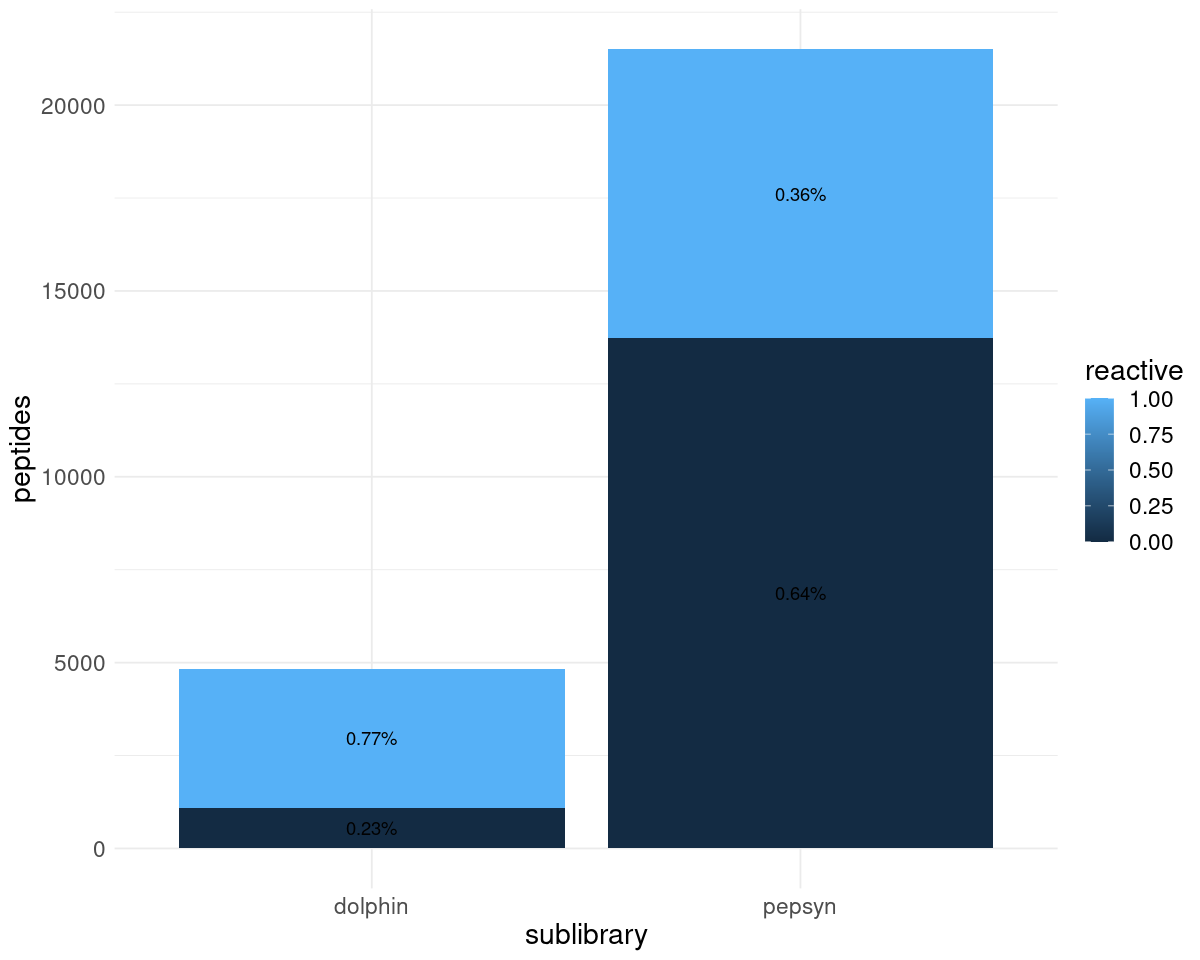

In [10]:
options(repr.plot.width=10, repr.plot.height=8)
evaldf %>% select(-total_peptides) %>% rename(peptides = react_peptides) %>% subset(sublibrary != "dolphinepitopes") %>%
ggplot(aes(fill=reactive, y=peptides, x=sublibrary)) + 
    geom_bar(position=position_stack(reverse = FALSE), stat="identity") +
    geom_text(aes(label=paste0(sprintf("%1.2f", ratio),"%")), position=position_stack(vjust=0.5)) 

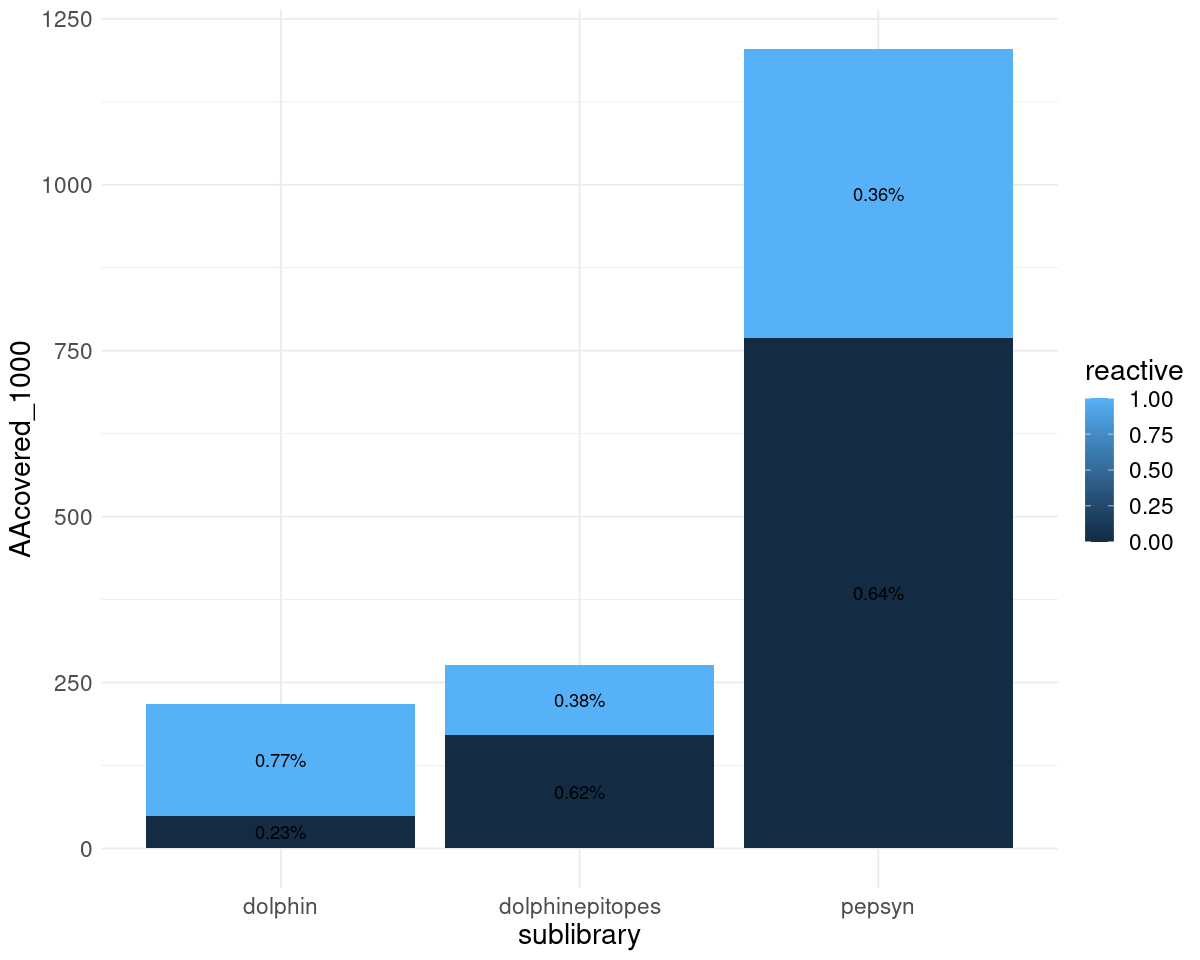

In [13]:
options(repr.plot.width=10, repr.plot.height=8)

evaldf %>% merge(data.frame(sublibrary=c("dolphin", "dolphinepitopes" , "pepsyn"),length=c(45,15,56)), by="sublibrary", all = TRUE) %>%
mutate(AAcovered_1000 = react_peptides * length / 1000)  %>% 
select(-total_peptides) %>% rename(peptides = react_peptides) %>%
ggplot(aes(fill=reactive, y=AAcovered_1000, x=sublibrary)) + 
    geom_bar(position=position_stack(reverse = FALSE), stat="identity") +
    geom_text(aes(label=paste0(sprintf("%1.2f", ratio),"%")), position=position_stack(vjust=0.5)) 

null device 
          1

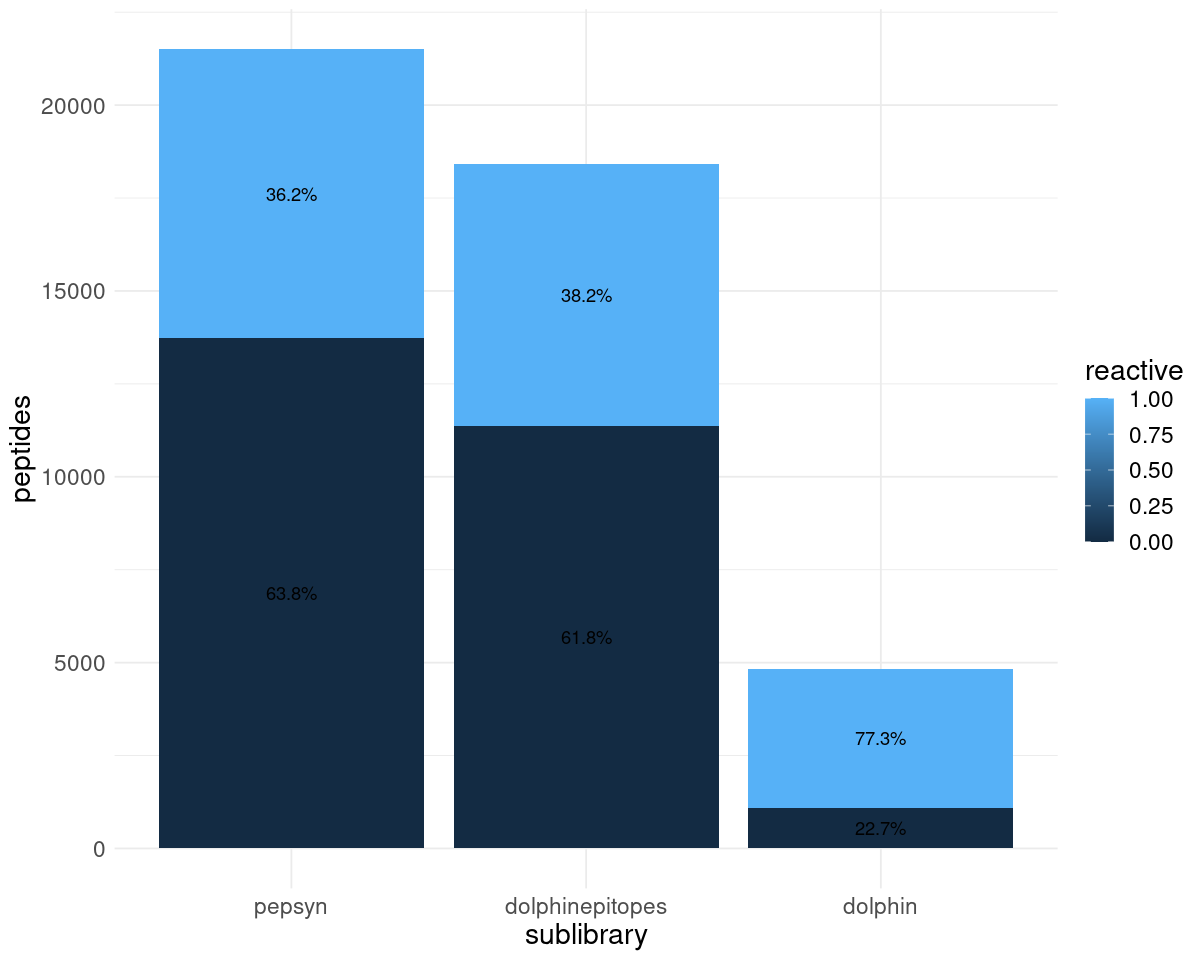

In [27]:
options(repr.plot.width=10, repr.plot.height=8)
#pdf("sublibraries_peptides.pdf", height = 8, width = 10)
evaldf %>% select(-total_peptides) %>% rename(peptides = react_peptides) %>%
mutate(sublibrary = factor(sublibrary, levels = c("pepsyn", "dolphinepitopes", "dolphin"))) %>%
ggplot(aes(fill=reactive, y=peptides, x=sublibrary)) + 
    geom_bar(position=position_stack(reverse = FALSE), stat="identity") +    
    geom_text(aes(label=paste0(sprintf("%1.1f", 100 * ratio),"%")), position=position_stack(vjust=0.5)) 

dev.off()

## Question

Whats the recall/discovery power per protein/phage?

In [128]:
options(repr.plot.width=10, repr.plot.height=8)

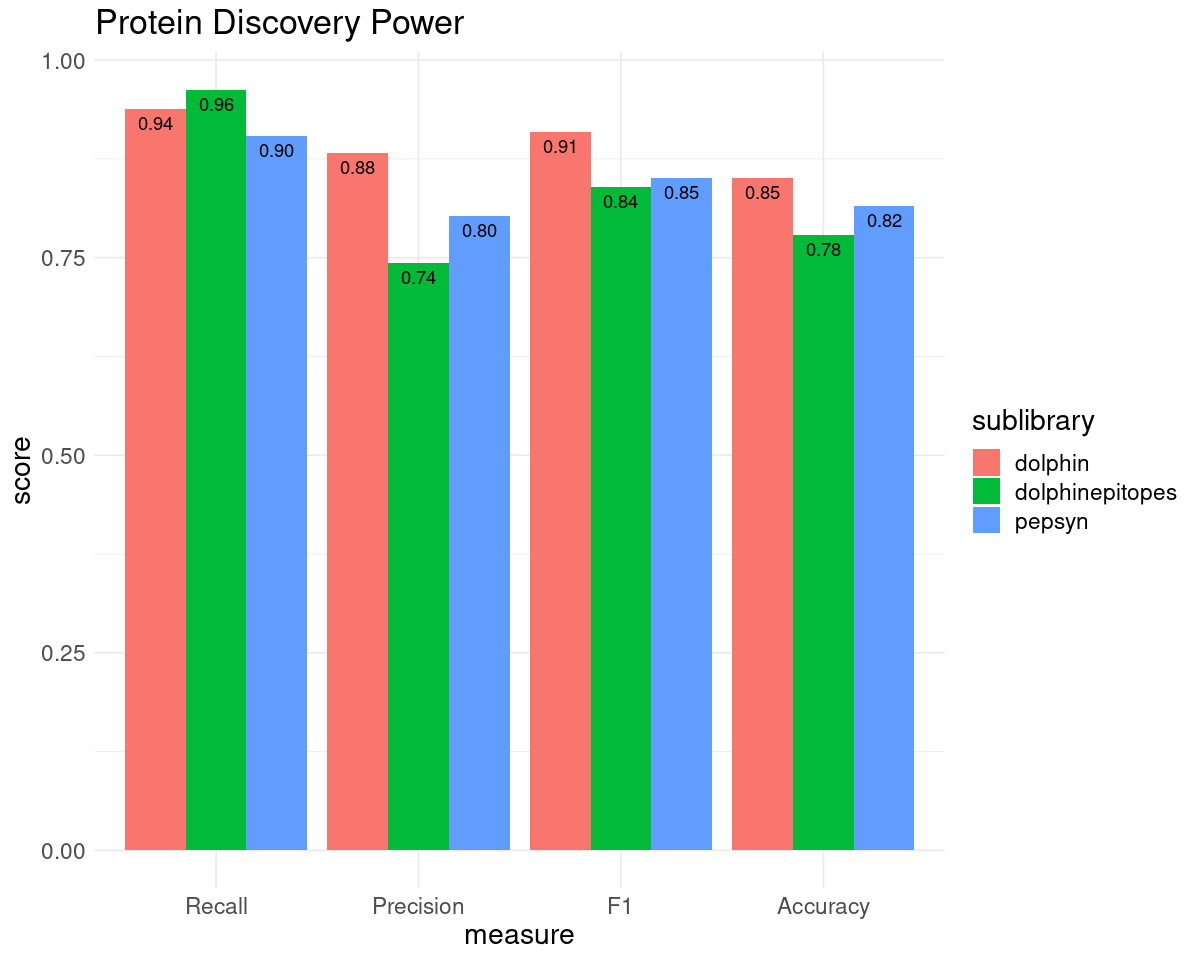

In [129]:
peps %>% aggregate(reactive ~ pro_id, data = ., FUN = sum) %>% mutate(protein_grountruth = as.numeric(reactive > 2)) %>% select(-reactive) ->> protein_truth
peps %>% aggregate(reactive ~ pro_id + sublibrary, data = ., FUN = max) %>% merge(protein_truth, by = "pro_id") ->> protein_df

protein_df %>% subset(protein_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) ->> recall_df

protein_df %>% subset(reactive == 1) %>% select(sublibrary, protein_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ protein_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) ->> prec_df

protein_df %>% subset(reactive == 0) %>% subset(protein_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") ->> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) ->> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Protein Discovery Power")

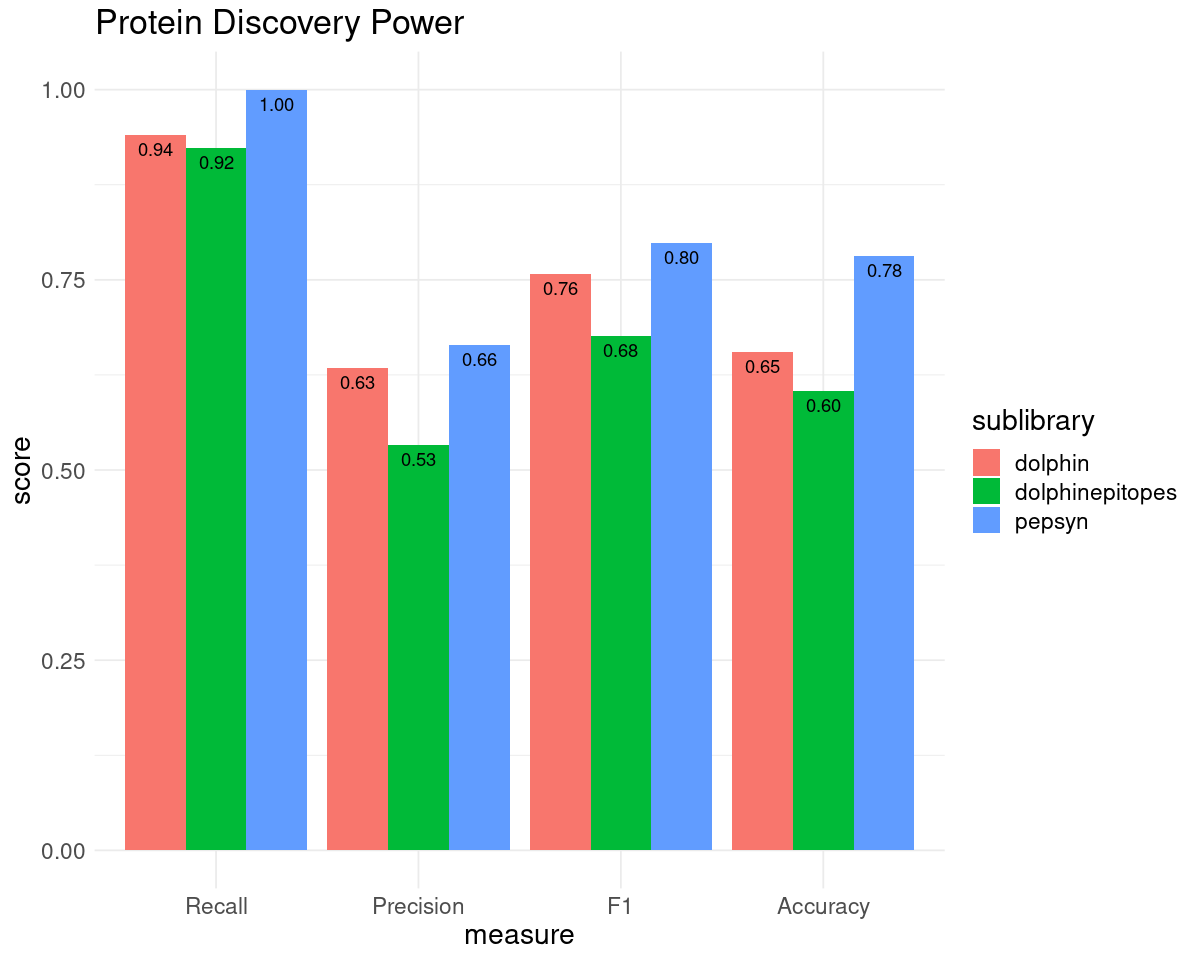

In [130]:
peps %>% subset(sublibrary=="pepsyn") %>% aggregate(reactive ~ pro_id, data = ., FUN = sum) %>% mutate(protein_grountruth = as.numeric(reactive > 1)) %>% select(-reactive) ->> pepsyn_protein_truth
peps %>% aggregate(reactive ~ pro_id + sublibrary, data = ., FUN = max) %>% merge(pepsyn_protein_truth, by = "pro_id") ->> protein_df

protein_df %>% subset(protein_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) ->> recall_df

protein_df %>% subset(reactive == 1) %>% select(sublibrary, protein_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ protein_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) ->> prec_df

protein_df %>% subset(reactive == 0) %>% subset(protein_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") ->> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) ->> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Protein Discovery Power")

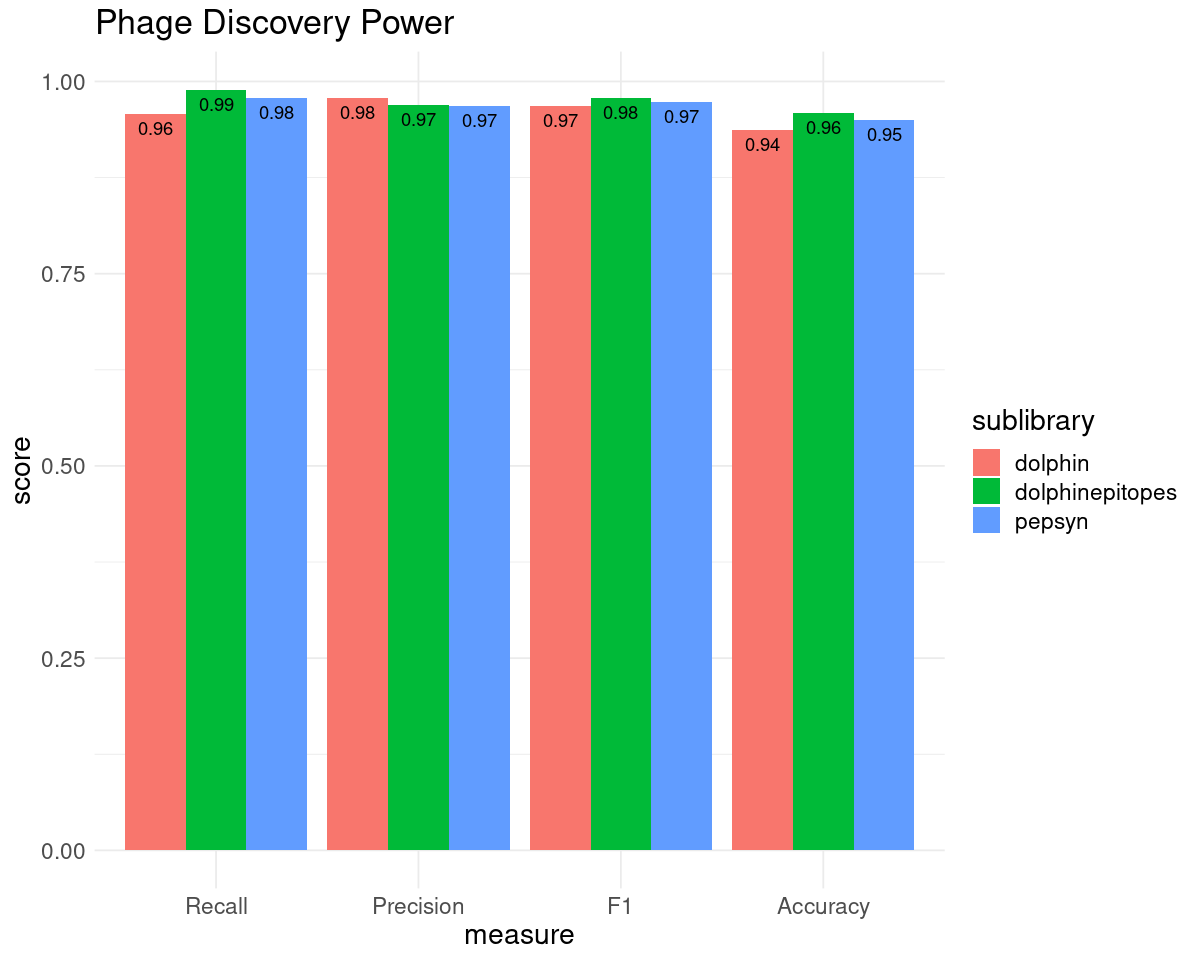

In [131]:
peps %>% aggregate(reactive ~ taxon_id, data = ., FUN = sum) %>% 
mutate(phage_grountruth = as.numeric(reactive > 2)) %>% select(-reactive) ->> phage_truth

peps %>% aggregate(reactive ~ taxon_id + sublibrary, data = ., FUN = max) %>% merge(phage_truth, by = "taxon_id") ->> phage_df

phage_df %>% subset(phage_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) ->> recall_df

phage_df %>% subset(reactive == 1) %>% select(sublibrary, phage_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ phage_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) ->> prec_df

phage_df %>% subset(reactive == 0) %>% subset(phage_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") ->> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) ->> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Phage Discovery Power") 

In [132]:
# decluster proteins for accurate discovery power of phages!
anno_pep %>% select(pro_id,pro_id_all) %>% distinct() %>% 
    mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
    mutate(pro_id_all = strsplit(pro_id_all,",")) ->> protein_clusters_map

p = protein_clusters_map$pro_id_all
names(p) <- protein_clusters_map$pro_id
protein_clusters = stack(p)

In [133]:
peps %>% merge(protein_clusters, by.x = 'pro_id', by.y = "ind", all = TRUE) %>% 
    rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>%
    select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) ->> peps_decluster

In [134]:
peps_decluster %>% aggregate(reactive ~ taxon_id, data = ., FUN = sum) %>% 
mutate(phage_grountruth = as.numeric(reactive > 20)) %>% select(-reactive) ->> phage_truth

peps_decluster %>% aggregate(reactive ~ taxon_id + sublibrary, data = ., FUN = max) %>% merge(phage_truth, by = "taxon_id") ->> phage_df

phage_df %>% subset(phage_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(TP="1") %>% mutate(FN=0) %>%
mutate(Recall = TP/(TP+FN))

sublibrary,TP,FN,Recall
<fct>,<int>,<dbl>,<dbl>
dolphin,112,0,1
dolphinepitopes,112,0,1
pepsyn,112,0,1


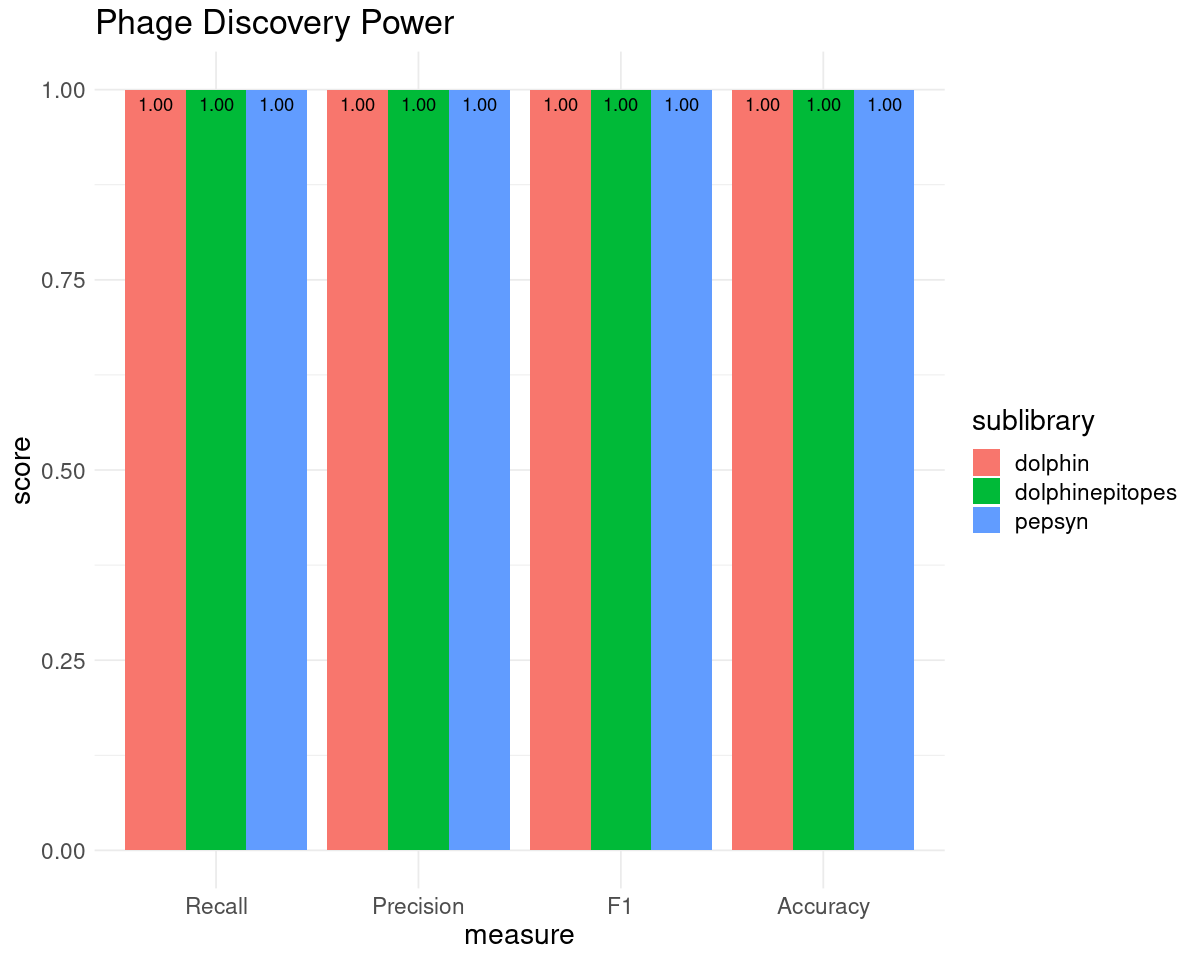

In [135]:
peps_decluster %>% aggregate(reactive ~ taxon_id, data = ., FUN = sum) %>% 
mutate(phage_grountruth = as.numeric(reactive > 10)) %>% select(-reactive) ->> phage_truth

peps_decluster %>% aggregate(reactive ~ taxon_id + sublibrary, data = ., FUN = max) %>% merge(phage_truth, by = "taxon_id") ->> phage_df

phage_df %>% subset(phage_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(TP="1") %>% mutate(FN=0) %>%
mutate(Recall = TP/(TP+FN)) ->> recall_df

phage_df %>% subset(reactive == 1) %>% select(sublibrary, phage_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ phage_grountruth, value.var = "Freq") %>% rename(TP="1") %>% mutate(FP=0) %>%
mutate(Precision = TP/(TP+FP)) ->> prec_df

phage_df %>% subset(reactive == 0) %>% subset(phage_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") ->> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) ->> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Phage Discovery Power") 

# Question
some kind of curve based on pepsyn groundtruth

In [136]:
anno_pep[anno_pep$containsResSite==FALSE ,c("pro_id","sublibrary")] %>% rownames_to_column("pepID") %>%
merge(lhfc %>% rownames_to_column("pepID")) %>% select(-contains("X196")) %>% select(-contains("X197")) %>%
select(-pepID) %>% group_by(sublibrary, pro_id) %>% mutate(rn = row_number()) ->
a

In [137]:
a %>% melt(id.vars = c("pro_id","sublibrary", "rn"), value.name = "lhfc", variable.name = "sample") %>% 
mutate(reactive = as.numeric(lhfc >0)) %>%
mutate(samplePro = paste(pro_id,sample)) %>% select(-lhfc) -> b

In [138]:
# which sample-protein pairs should be reactive according to pepsyn?
b %>% subset(sublibrary == "pepsyn") %>% 
aggregate(reactive ~ samplePro, data = ., FUN = max) %>% 
subset(reactive > 0) %>% select(-reactive) -> pepsynGT

In [139]:
b %>% subset(samplePro %in% pepsynGT$samplePro) %>% #only use sample-protein pairs that should be reactive (-> recall)
aggregate(reactive ~ rn + sublibrary, data = ., FUN = sum) %>% # count discovered epitopes after including 1 more peptide per library and protein 
dcast(rn ~ sublibrary, value.var = "reactive") %>% subset(!is.na(dolphin)) %>% #stop including peptides in other libraries when pepsyn is at max
melt(id.vars = "rn", value.name = "reactive", variable.name = "sublibrary") %>% #shape back
group_by(sublibrary) %>% mutate(cum_reactive = cumsum(reactive)) %>% # accumulate detected reactivities over included peptides
mutate(perAA = ifelse(sublibrary=="dolphinepitopes", rn*15,rn*56)) -> d # make number per synthesized amino acid


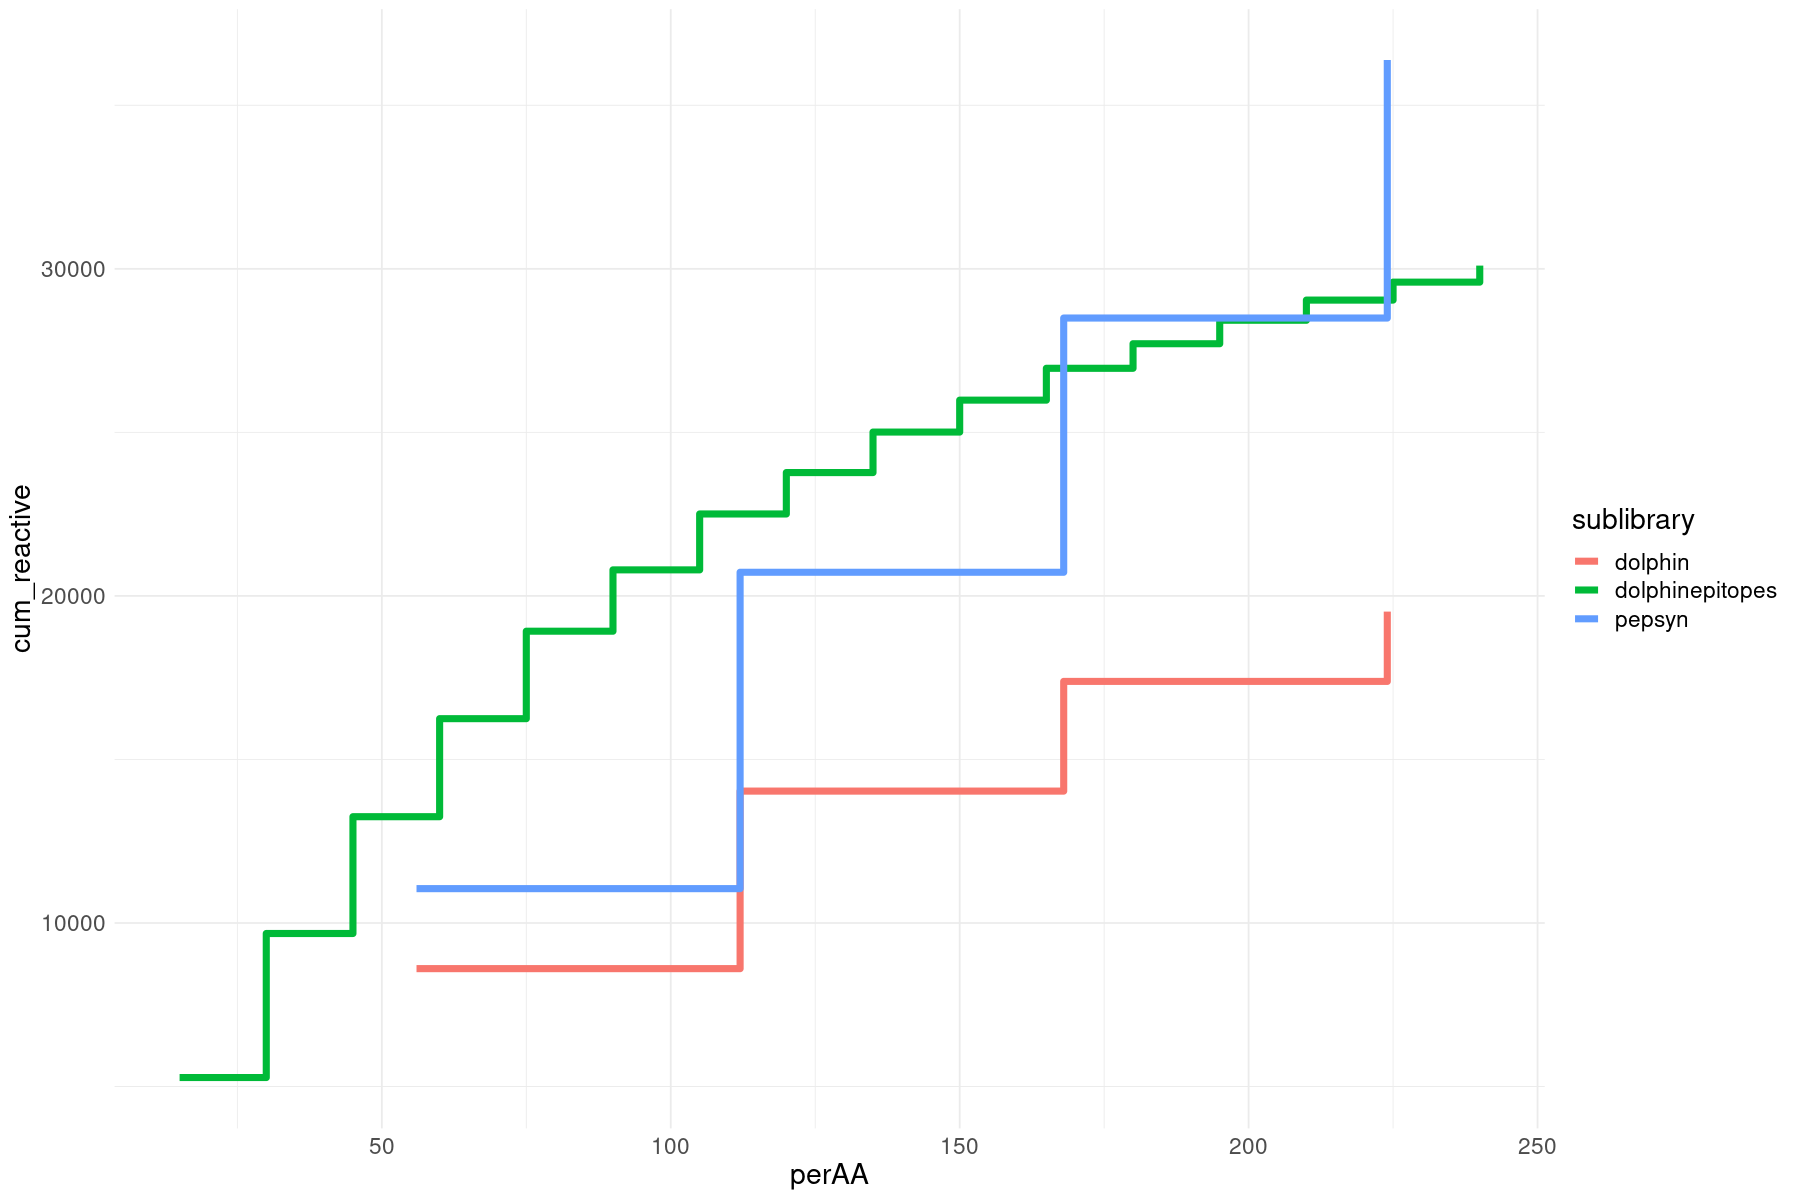

In [140]:
options(repr.plot.width=15, repr.plot.height=10)
d %>% subset(perAA<250) %>% group_by(sublibrary) %>% mutate(cum_reactive = cumsum(reactive)) %>% 
ggplot(aes(x=perAA, y = cum_reactive, color = sublibrary)) + geom_step(size=2)

In [141]:
# which sample-protein pairs should be reactive according to pepsyn?
b %>% aggregate(reactive ~ samplePro, data = ., FUN = max) %>% 
subset(reactive > 0) %>% select(-reactive) -> fairGT

In [142]:
b %>% subset(samplePro %in% fairGT$samplePro) %>% #only use sample-protein pairs that should be reactive (-> recall)
aggregate(reactive ~ rn + sublibrary, data = ., FUN = sum) %>% # count discovered epitopes after including 1 more peptide per library and protein 
dcast(rn ~ sublibrary, value.var = "reactive") %>% subset(!is.na(dolphin)) %>% #stop including peptides in other libraries when pepsyn is at max
melt(id.vars = "rn", value.name = "reactive", variable.name = "sublibrary") %>% #shape back
group_by(sublibrary) %>% mutate(cum_reactive = cumsum(reactive)) %>% # accumulate detected reactivities over included peptides
mutate(perAA = ifelse(sublibrary=="dolphinepitopes", rn*15,rn*56)) -> d # make number per synthesized amino acid


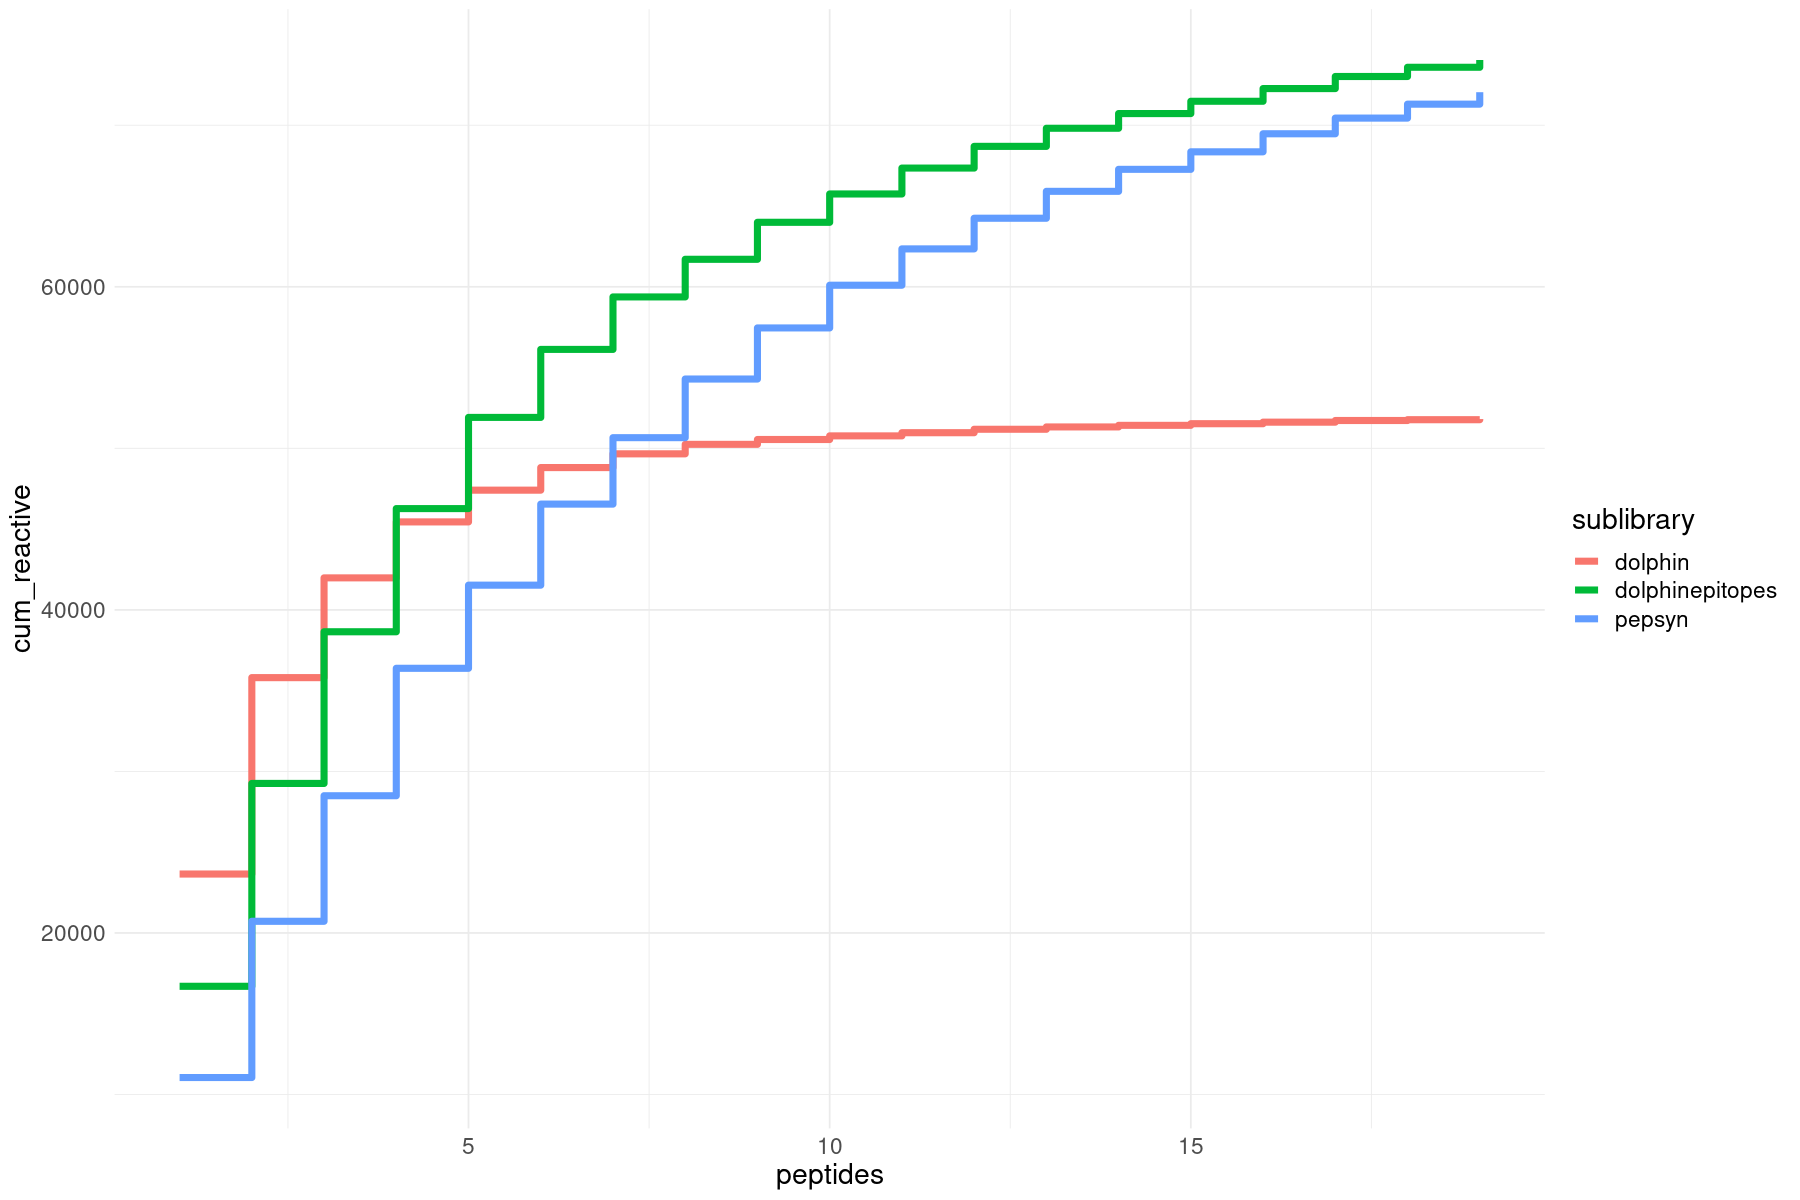

In [143]:
d %>% subset(rn<20) %>% rename(peptides=rn) %>% group_by(sublibrary) %>% mutate(cum_reactive = cumsum(reactive)) %>% 
ggplot(aes(x=peptides, y = cum_reactive, color = sublibrary)) + geom_step(size=2) 

In [144]:
as.data.frame(lhfc>0) %>% mutate_if(is.logical, as.numeric) -> lhfc_bin

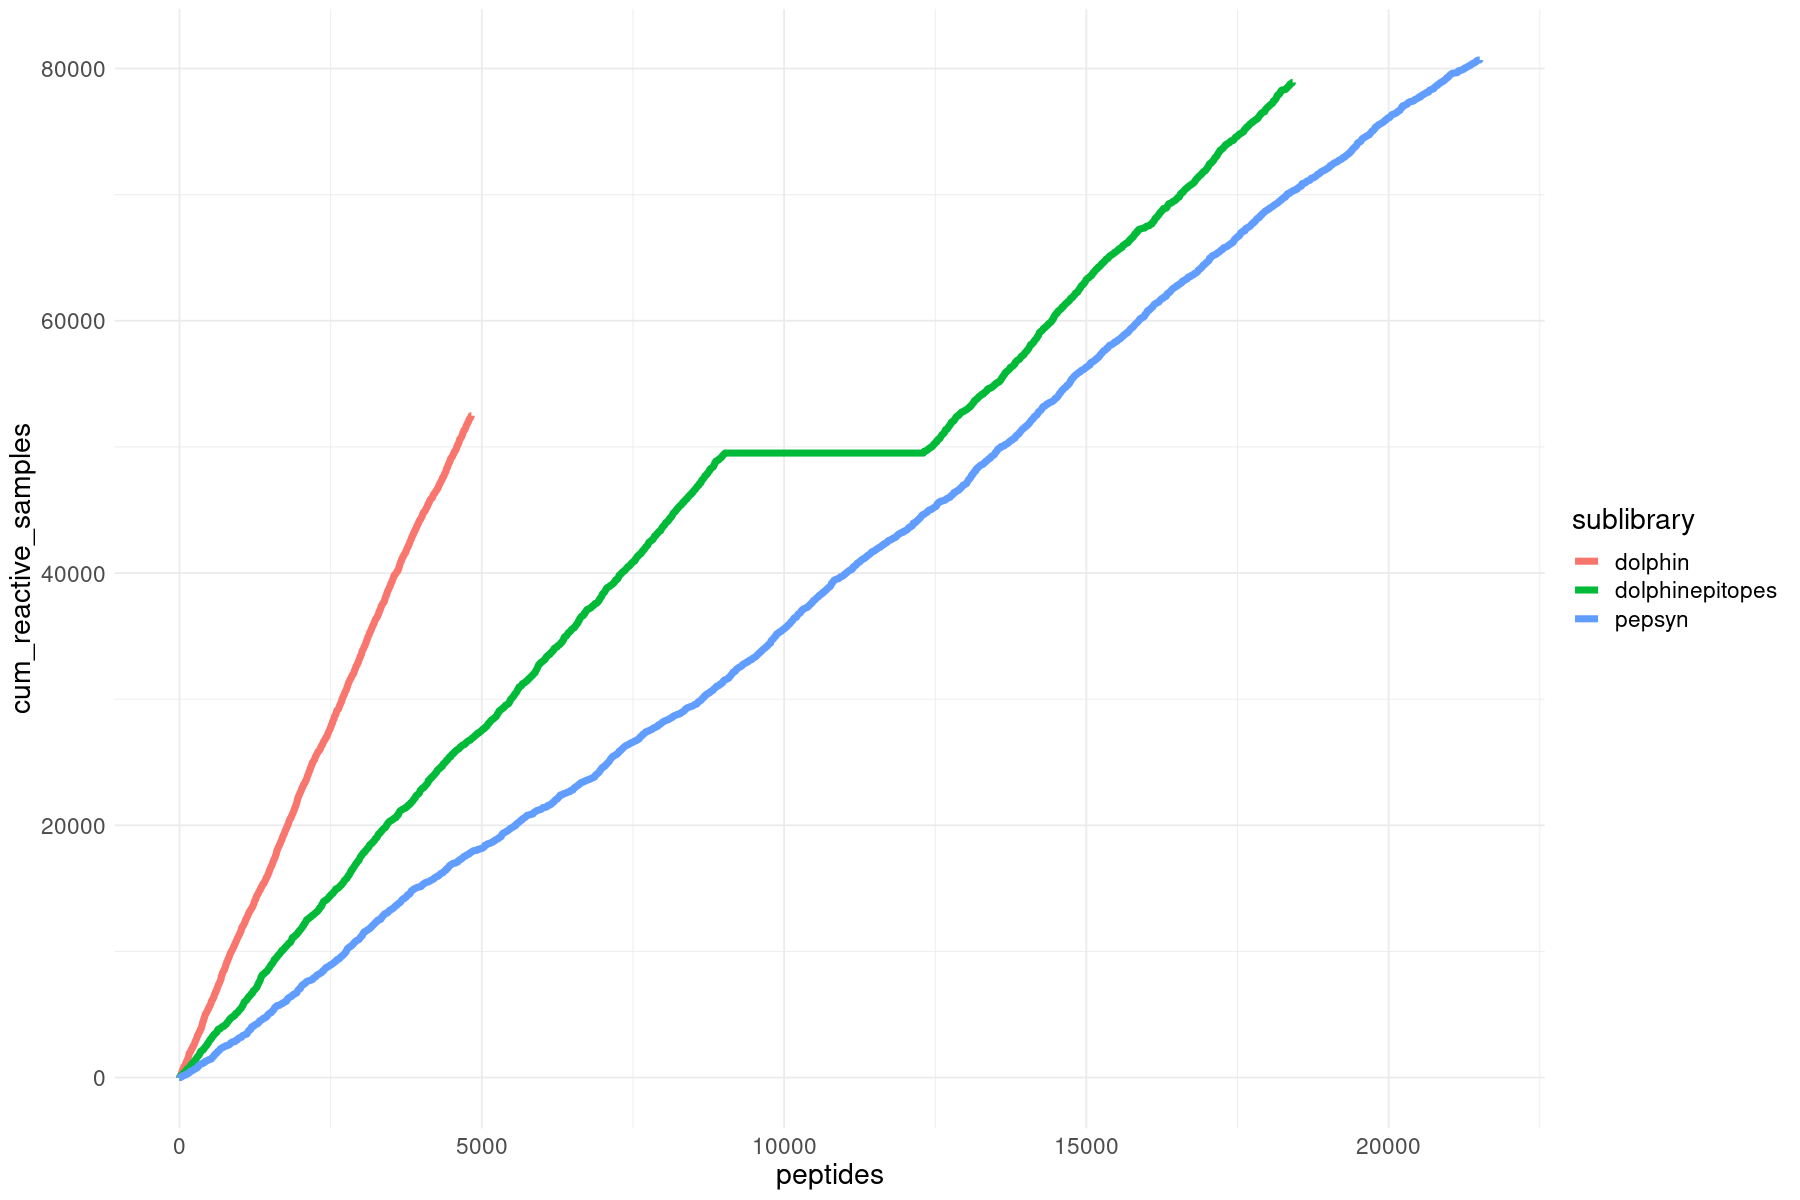

In [145]:
anno_pep[anno_pep$containsResSite==FALSE ,c("pro_id","sublibrary")] %>% rownames_to_column("pepID") %>%
merge(.,lhfc_bin %>% select(-contains("X196")) %>% select(-contains("X197")) %>% mutate(reactivesamples = rowSums(.)) %>%
    rownames_to_column("pepID") %>% select(-contains("X194")) %>% select(-contains("X195"))) %>%
select(-pepID) %>% group_by(sublibrary) %>% mutate(peptides = row_number()) %>% mutate(cum_reactive_samples = cumsum(reactivesamples)) %>% 
ggplot(aes(x=peptides, y = cum_reactive_samples, color = sublibrary)) + geom_step(size=2) 

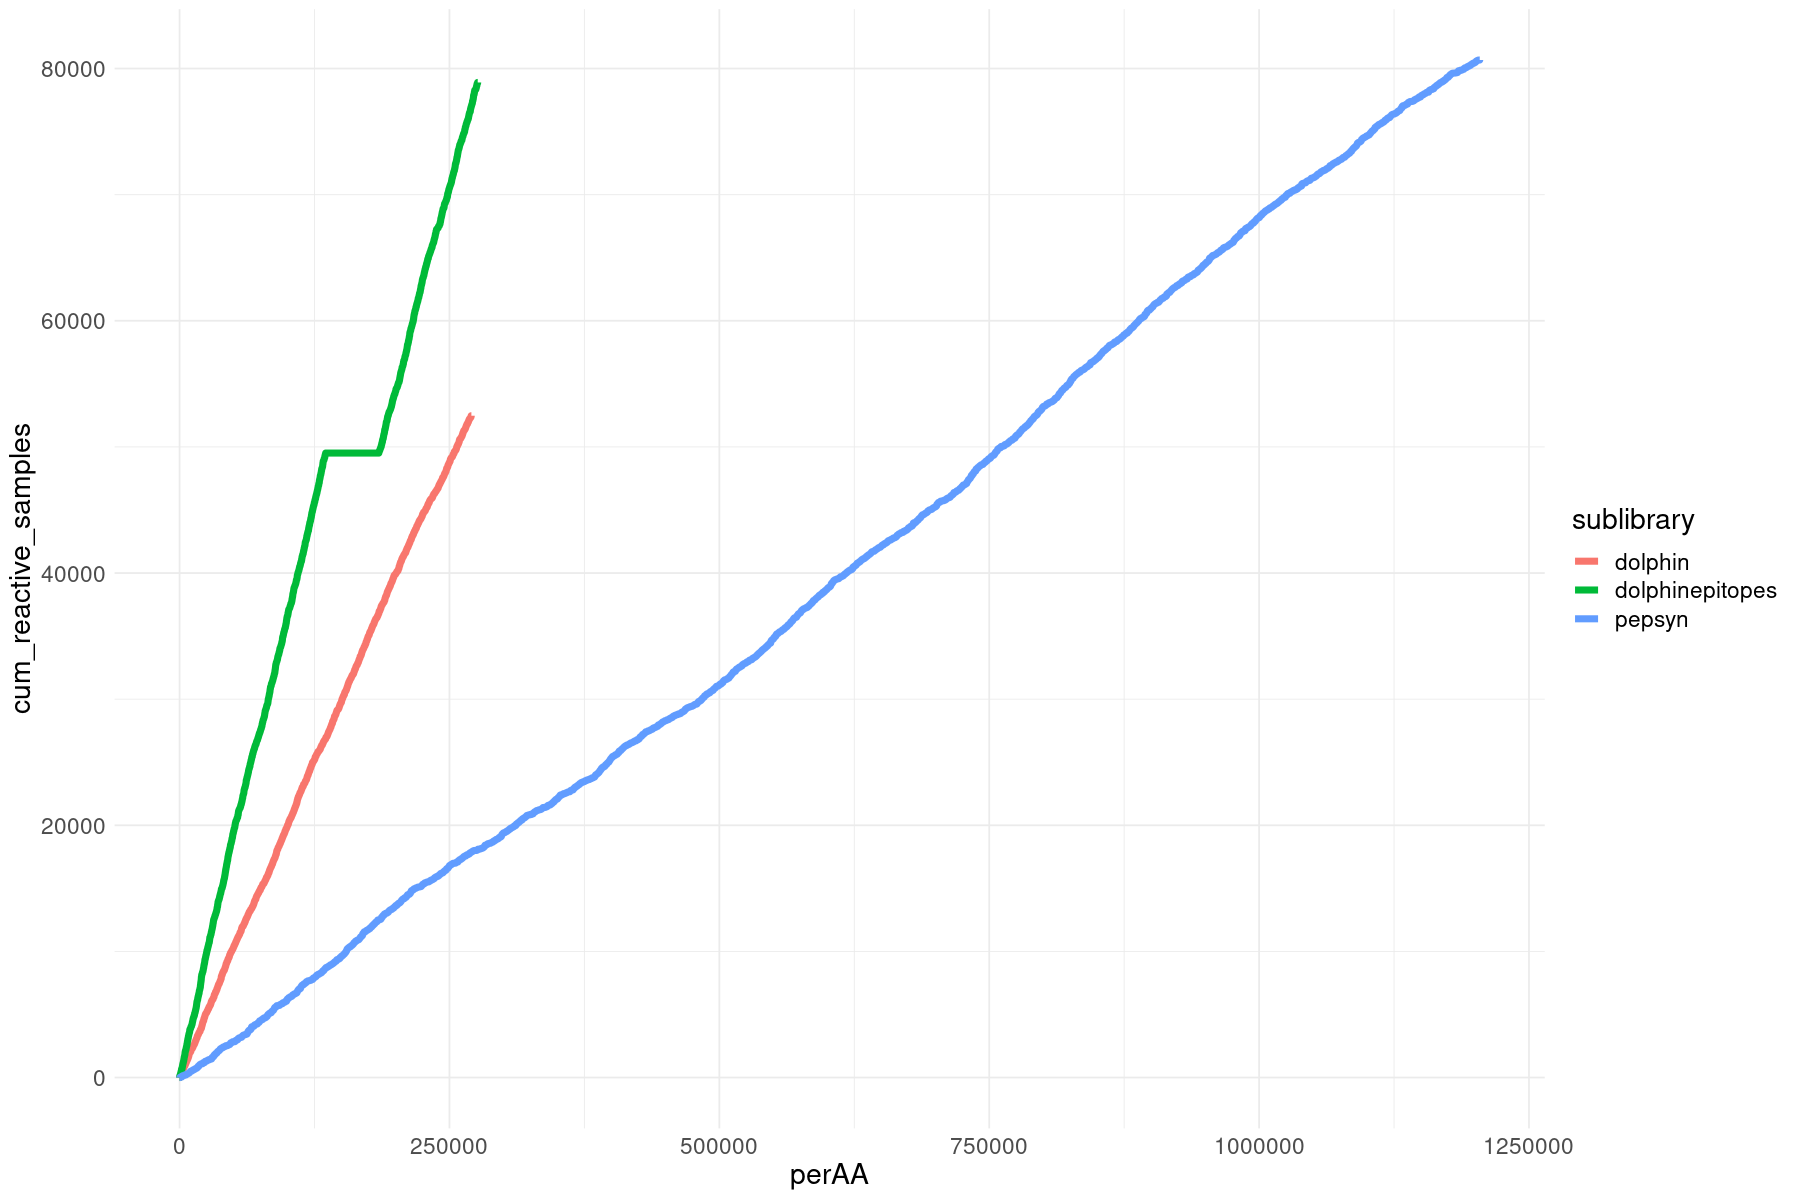

In [146]:
anno_pep[anno_pep$containsResSite==FALSE ,c("pro_id","sublibrary")] %>% rownames_to_column("pepID") %>%
merge(.,lhfc_bin %>% select(-contains("X196")) %>% select(-contains("X197")) %>% mutate(reactivesamples = rowSums(.)) %>%
    rownames_to_column("pepID") %>% select(-contains("X194")) %>% select(-contains("X195"))) %>%
select(-pepID) %>% group_by(sublibrary) %>% mutate(peptides = row_number()) %>% mutate(cum_reactive_samples = cumsum(reactivesamples)) %>% 
mutate(perAA = ifelse(sublibrary=="dolphinepitopes", peptides*15,peptides*56)) %>%
ggplot(aes(x=perAA, y = cum_reactive_samples, color = sublibrary)) + geom_step(size=2) 

In [147]:
rawanno = read.table("phageome_tiles_annotation_all.csv", sep=",", header = TRUE, row.names = 1, stringsAsFactors=FALSE)

In [148]:
rawanno %>% subset(library == "dolphinepitopes") %>% select(tile_id.1,allinfo,AA)  %>% 
mutate(RFproba = sub(".*_", "", allinfo)) %>% mutate(RFproba =  as.numeric(RFproba)) %>% 
mutate(AA = substr(AA,6,20)) %>%
select(-allinfo) %>% rename(tile_id = tile_id.1) %>% remove_rownames() %>% column_to_rownames("AA") %>% select(-tile_id) -> epitopeProbas

getProba = function(epi){
        return(epitopeProbas[epi,"RFproba"])
}

In [149]:
rawanno %>% subset(library == "dolphin") %>% select(AA,tile_id.1,allinfo) %>%
mutate(Epi1 = substr(AA,1,15)) %>%
mutate(Epi2 = substr(AA,21,35)) %>%
mutate(Epi3 = substr(AA,41,55)) %>% select(-allinfo,-AA) %>%
melt(id.vars = "tile_id.1", value.name = "AA", variable.name = "epitope") %>% mutate(epiProba = getProba(AA)) %>%
rename(tile_id = tile_id.1) %>%
group_by(tile_id) %>% summarise_at("epiProba",list(meanProba = mean, firstEpiProba = max)) %>% column_to_rownames("tile_id") -> dolphynProbas


In [150]:
rawanno %>% select(library,tile_id.1,allinfo) %>% subset(!library %in% c("validationDS","monkeyvir")) %>% rename(tile_id = tile_id.1) %>% 
mutate(RFproba = sub(".*_", "", allinfo)) %>% mutate(RFproba = case_when(library=="dolphinepitopes" ~ as.numeric(RFproba),
                         library=="dolphin" ~ dolphynProbas[tile_id,"firstEpiProba"],
                         library=="pepsyn" ~ 0.5)) %>% 
select(-allinfo, -library) -> tileProbas

Warning message in eval_tidy(pair$rhs, env = default_env):
“NAs introduced by coercion”


In [151]:
set.seed(3)
anno_pep[anno_pep$containsResSite==FALSE ,c("tile_id","pro_id","sublibrary")] %>% rownames_to_column("pepID") %>%
merge(lhfc %>% rownames_to_column("pepID")) %>% select(-contains("X196")) %>% select(-contains("X197")) %>%
merge(tileProbas) %>%
select(-pepID)  %>% melt(id.vars = c("pro_id","sublibrary","RFproba"), value.name = "lhfc", variable.name = "sample") %>% 
mutate(reactive = as.numeric(lhfc >0)) %>%
mutate(samplePro = paste(pro_id,sample)) %>% select(-lhfc) %>%
sample_frac(1L) %>% arrange(desc(RFproba)) %>%
group_by(sublibrary) %>% mutate(rn = row_number()) -> b

Warning message:
“attributes are not identical across measure variables; they will be dropped”


In [152]:
b

pro_id,sublibrary,RFproba,sample,reactive,samplePro,rn
<fct>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<int>
uvig_357441_78,dolphin,0.8833333,SMART321X194,0,uvig_357441_78 SMART321X194,1
uvig_357441_78,dolphin,0.8833333,SMART331X194,0,uvig_357441_78 SMART331X194,2
uvig_357441_78,dolphinepitopes,0.8833333,SMART332X194,0,uvig_357441_78 SMART332X194,1
uvig_357441_78,dolphin,0.8833333,SO.0761.01X194,0,uvig_357441_78 SO.0761.01X194,3
uvig_357441_78,dolphin,0.8833333,SO.0665.01X194,0,uvig_357441_78 SO.0665.01X194,4
uvig_357441_78,dolphin,0.8833333,SMART036X194,0,uvig_357441_78 SMART036X194,5
uvig_357441_78,dolphin,0.8833333,SMART235X195,0,uvig_357441_78 SMART235X195,6
uvig_357441_78,dolphinepitopes,0.8833333,S3.0748.01X194,0,uvig_357441_78 S3.0748.01X194,2
uvig_357441_78,dolphin,0.8833333,SMART266X195,0,uvig_357441_78 SMART266X195,7


In [153]:
# which sample-protein pairs should be reactive according to pepsyn?
#b %>% subset(sublibrary == "pepsyn") %>% 
#aggregate(reactive ~ samplePro, data = ., FUN = max) %>% 
#subset(reactive > 0) %>% select(-reactive) -> pepsynGT

In [154]:
b %>% mutate(hitGT = ifelse((samplePro %in% pepsynGT$samplePro) & reactive,1,0)) %>% #mark discovered reactivity
arrange(rn) %>% group_by(sublibrary) %>% mutate(cum_detected = cumsum(hitGT)) %>% # accumulate detected reactivities over included peptides
mutate(perAA = case_when(sublibrary=="dolphinepitopes" ~ rn*15,
                         sublibrary=="dolphin" ~ rn*45,
                         sublibrary=="pepsyn" ~ rn*56)) -> c # make number per synthesized amino acid

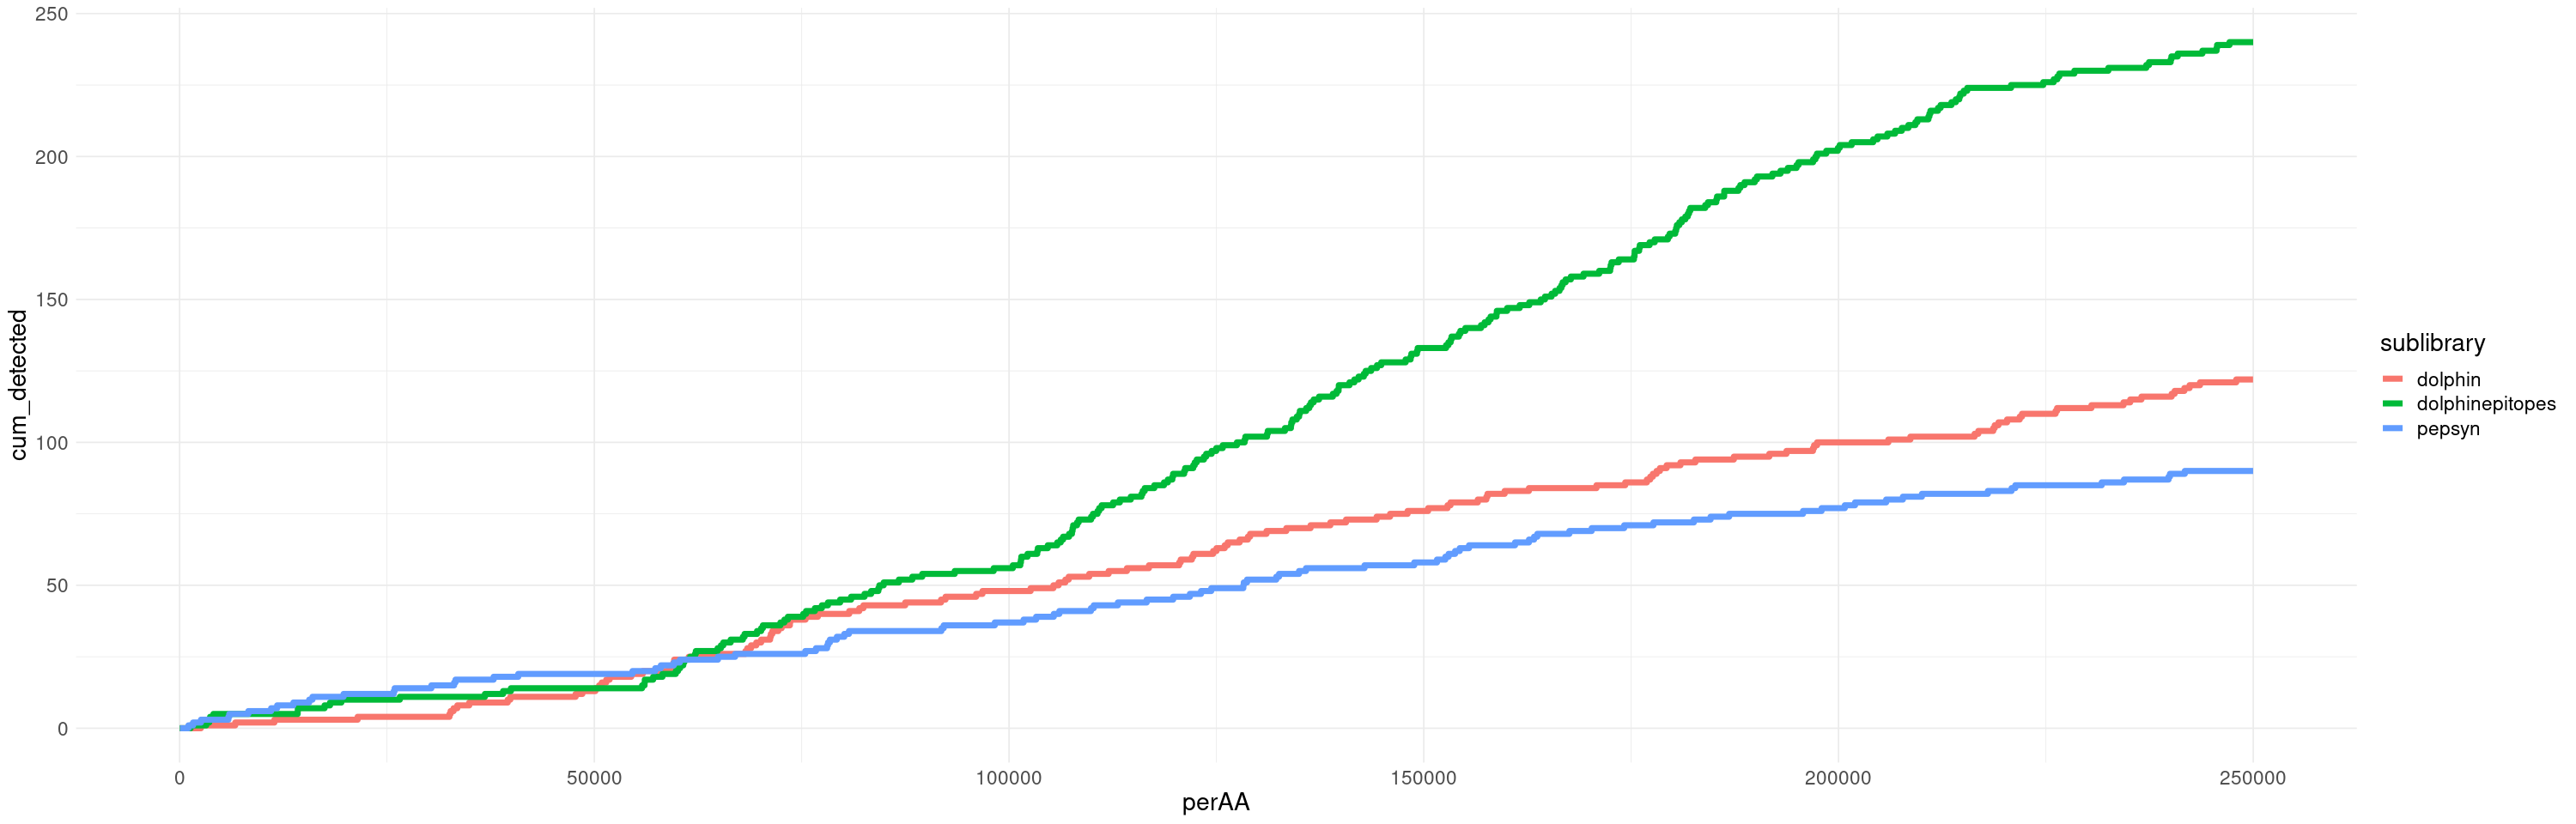

In [155]:
options(repr.plot.width=25, repr.plot.height=8)
c %>% subset(perAA<250000) %>% 
ggplot(aes(x=perAA, y = cum_detected, color = sublibrary)) + geom_step(size=2)

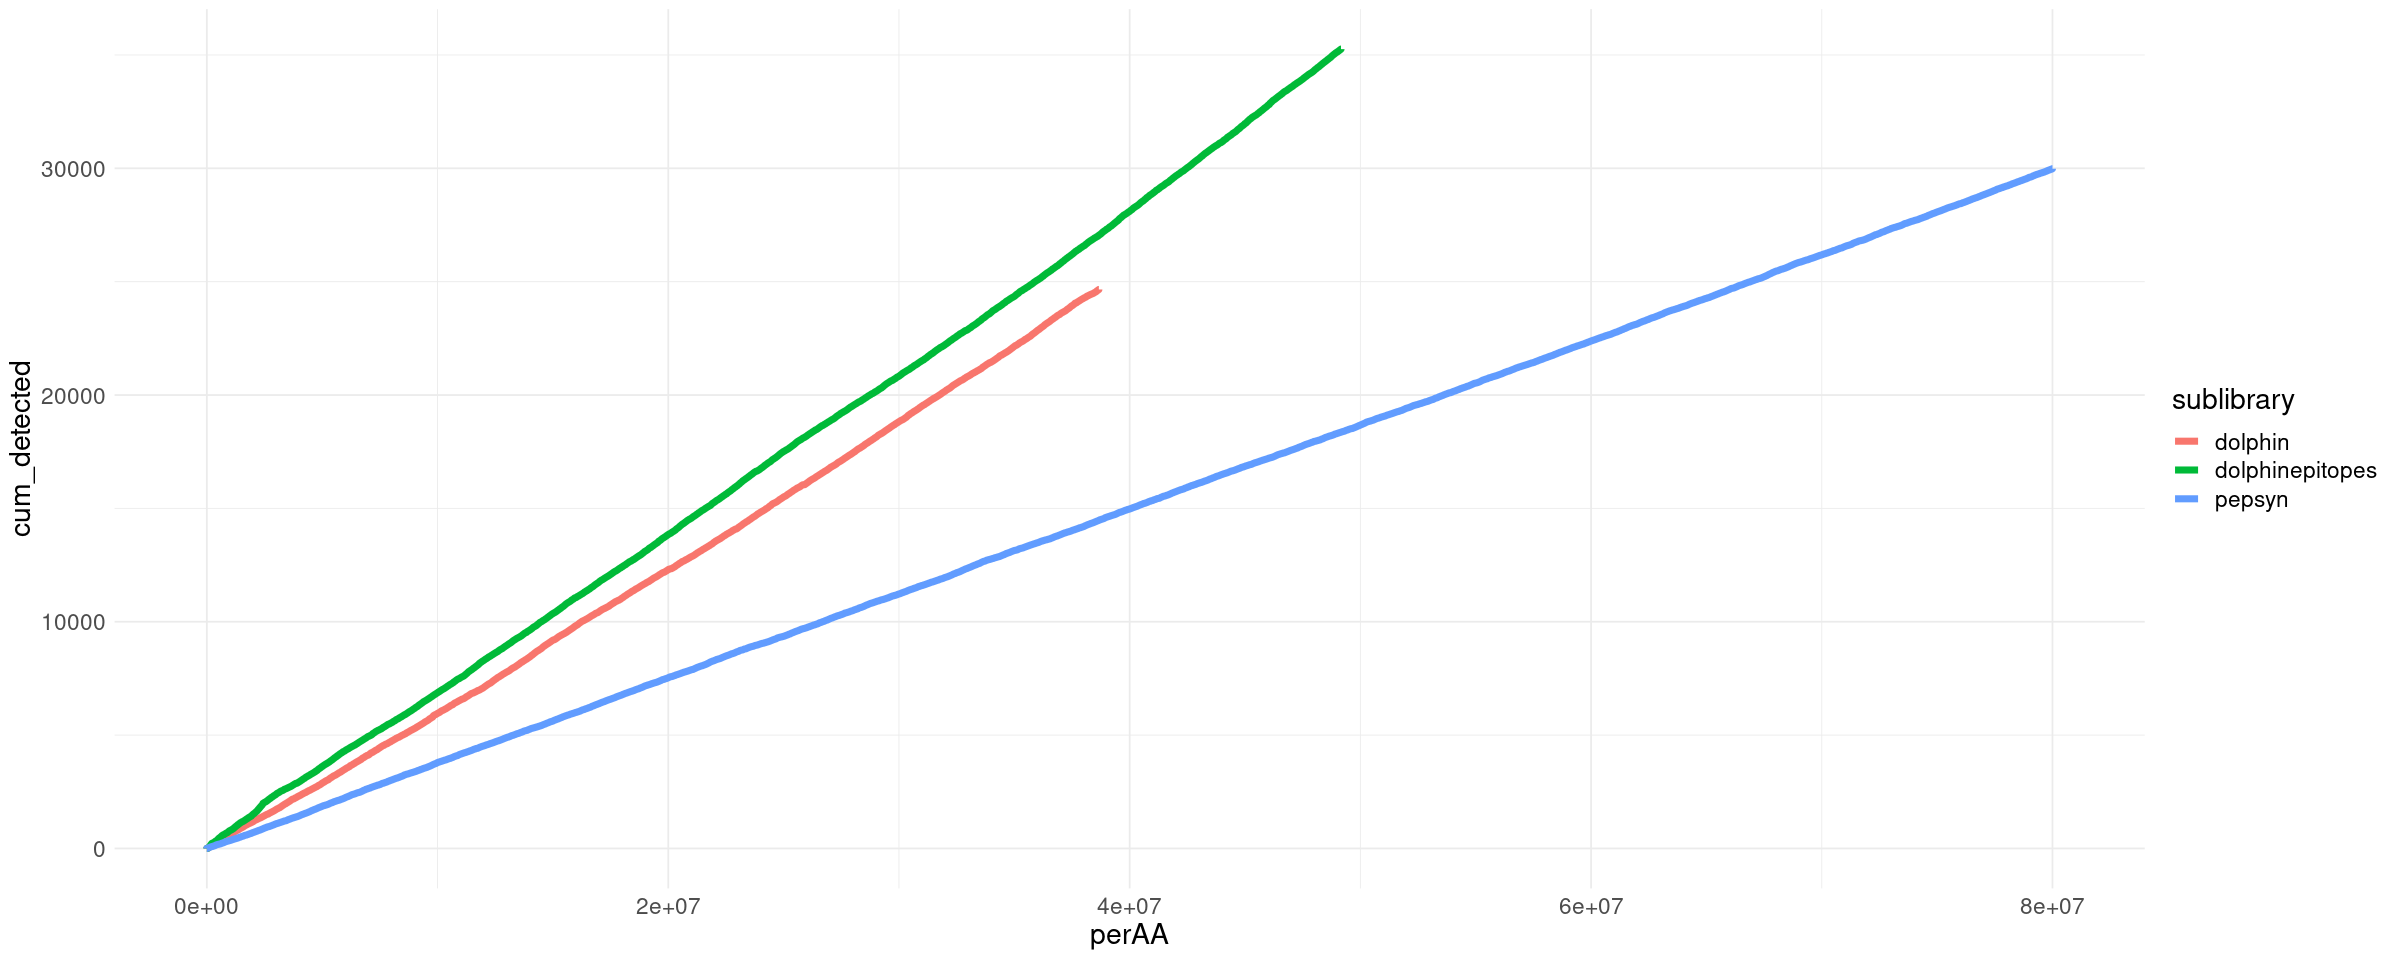

In [156]:
options(repr.plot.width=20, repr.plot.height=8)
c %>% subset(perAA<80000000) %>% 
ggplot(aes(x=perAA, y = cum_detected, color = sublibrary)) + geom_step(size=2)

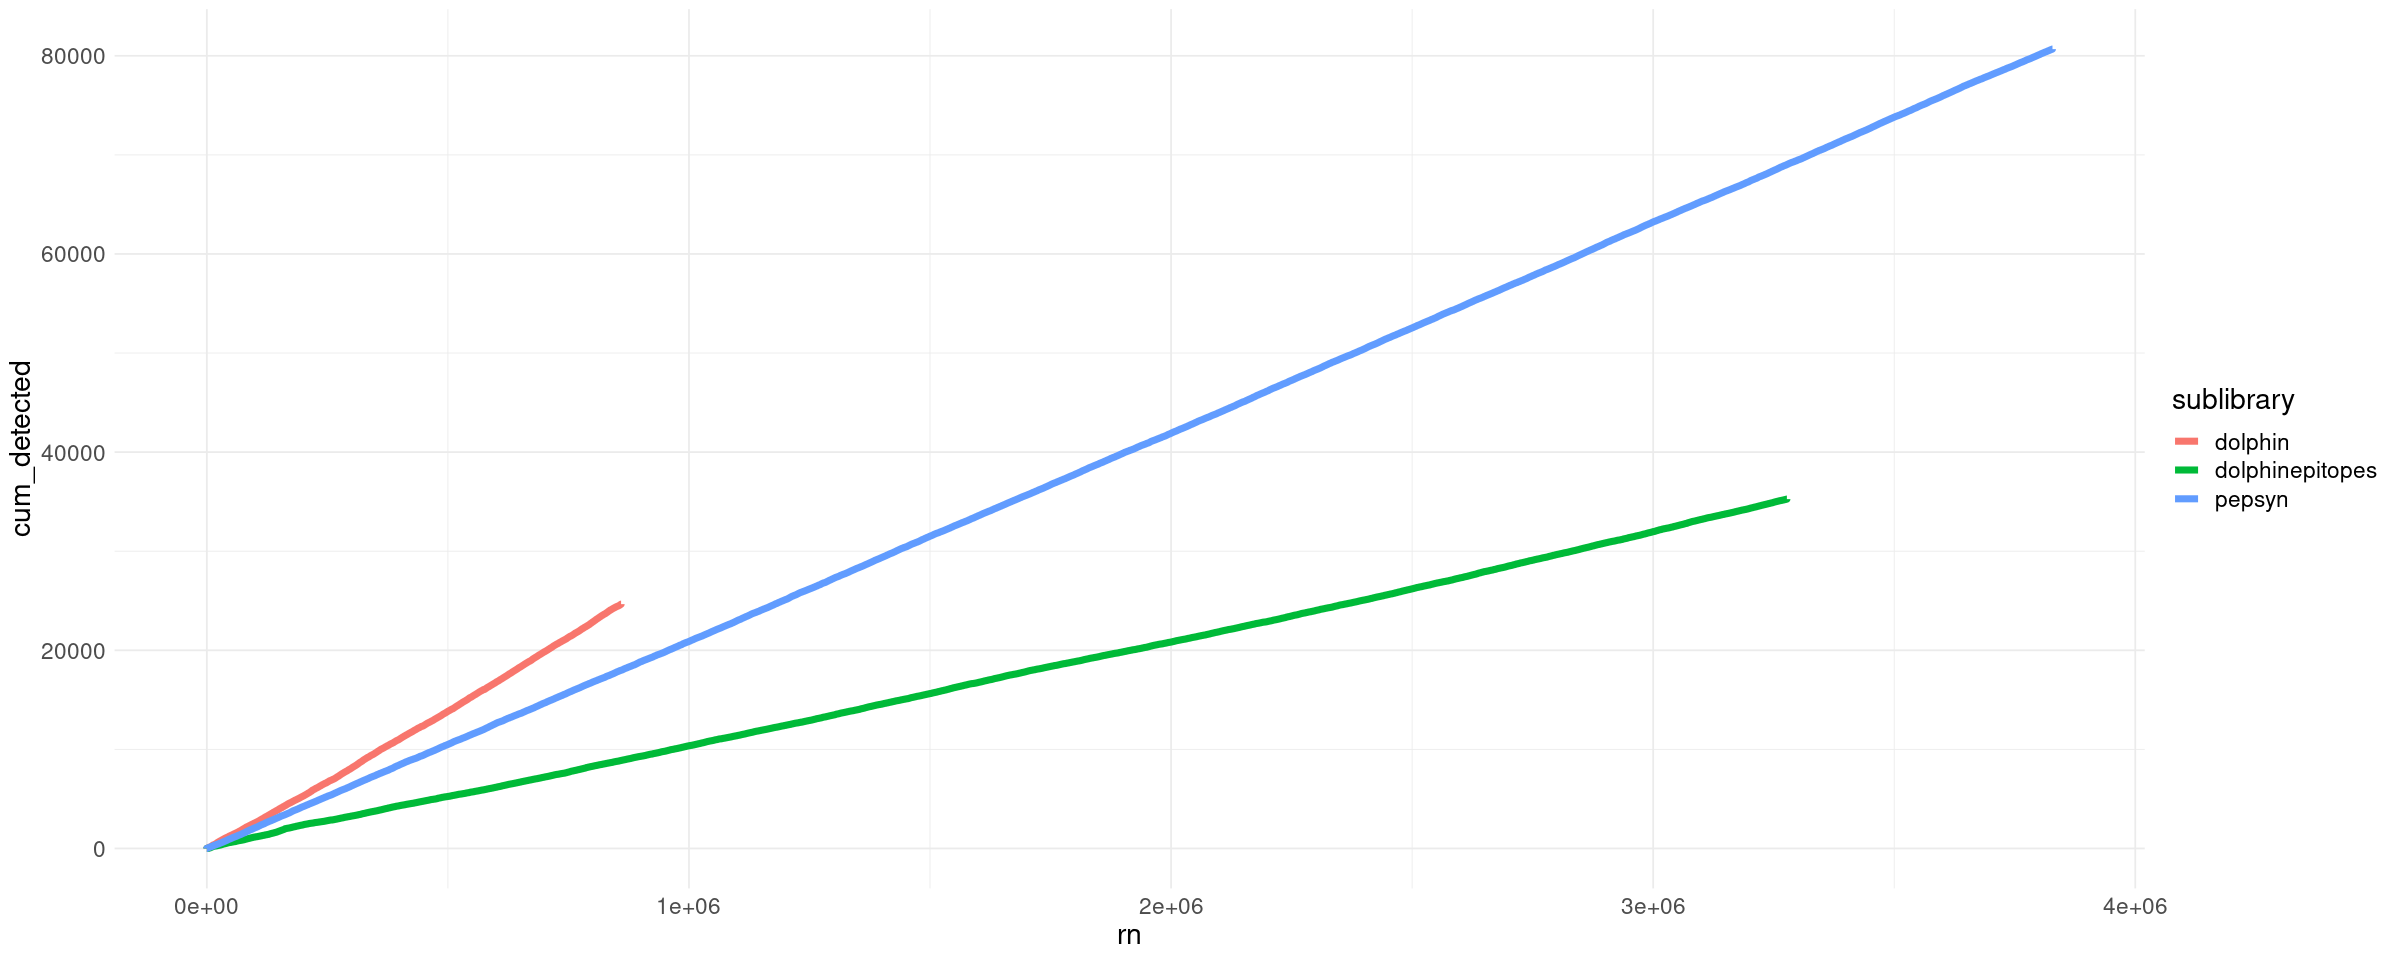

In [157]:
options(repr.plot.width=20, repr.plot.height=8)
c %>% #subset(rn<25000) %>% 
ggplot(aes(x=rn, y = cum_detected, color = sublibrary)) + geom_step(size=2)

In [158]:
evaldf %>% select(-reactive) %>% subset(sublibrary != "dolphinepitopes") %>% 
melt(id.vars = c("ratio","sublibrary"), variable.name = "peptides", value.name = "number")

ratio,sublibrary,peptides,number
<dbl>,<fct>,<fct>,<int>
0.2266418,dolphin,react_peptides,1094
0.7733582,dolphin,react_peptides,3733
0.6384433,pepsyn,react_peptides,13731
0.3615567,pepsyn,react_peptides,7776
0.2266418,dolphin,total_peptides,4827
0.7733582,dolphin,total_peptides,4827
0.6384433,pepsyn,total_peptides,21507
0.3615567,pepsyn,total_peptides,21507


In [159]:
evaldf

sublibrary,reactive,react_peptides,total_peptides,ratio
<fct>,<dbl>,<int>,<int>,<dbl>
dolphin,0,1094,4827,0.2266418
dolphin,1,3733,4827,0.7733582
dolphinepitopes,0,11370,18412,0.6175320
dolphinepitopes,1,7042,18412,0.3824680
pepsyn,0,13731,21507,0.6384433
pepsyn,1,7776,21507,0.3615567


In [160]:
lhfc_igg = lhfc[rownames(anno_pep),grepl("X194", colnames(lhfc)) | grepl("X195", colnames(lhfc))]
lhfc_iga = lhfc[rownames(anno_pep),grepl("X196", colnames(lhfc)) | grepl("X197", colnames(lhfc))]

In [161]:
df = cbind(anno_pep[,c("pro_id","pos_start","pro_len","taxon_id", "sublibrary")],max_IgG = apply(lhfc_igg, 1, max))
df = cbind(df, max_IgA = apply(lhfc_iga, 1, max))

In [162]:
df = merge(aggregate(max_IgG ~ pro_id + pro_len + taxon_id + sublibrary, data = df, FUN = length), 
           aggregate(cbind(max_IgG,max_IgA) ~ pro_id + sublibrary, data = df, FUN = max), by = c("pro_id","sublibrary"))
names(df) = c('pro_id','sublibrary','pro_len','taxon_id','tiles_aggregated','max_IgG','max_IgA')

In [163]:
df2 = merge(dcast(df, pro_id + pro_len + taxon_id ~ sublibrary, value.var = "max_IgA"),
            dcast(df, pro_id + pro_len + taxon_id ~ sublibrary, value.var = "max_IgG"),
            by=c('pro_id','pro_len','taxon_id'))
df2 = merge(df2, dcast(df, pro_id + pro_len + taxon_id ~ sublibrary, value.var = "tiles_aggregated"), by=c('pro_id','pro_len','taxon_id'))

In [164]:
names(df2) = c('pro_id','pro_len','taxon_id',
               'dolphyn_max_IgA', 'predEpis_max_IgA', 'pepsyn_max_IgA', 
               'dolphyn_max_IgG', 'predEpis_max_IgG', 'pepsyn_max_IgG',
               'dolphyn_tiles', 'predEpis_tiles', 'pepsyn_tiles')

In [165]:
df2

pro_id,pro_len,taxon_id,dolphyn_max_IgA,predEpis_max_IgA,pepsyn_max_IgA,dolphyn_max_IgG,predEpis_max_IgG,pepsyn_max_IgG,dolphyn_tiles,predEpis_tiles,pepsyn_tiles
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
ivig_1166_16,725,ivig_1166,3.011606,2.319442,2.190536,3.949319,4.408669,5.823667,6,19,24
ivig_1166_2,30,ivig_1166,NA,0.000000,0.000000,NA,0.000000,0.000000,NA,1,1
ivig_1166_7,306,ivig_1166,1.824549,2.013569,1.629241,4.275415,3.295096,1.925707,3,9,10
ivig_1166_8,376,ivig_1166,1.658228,2.025513,2.248129,2.478218,2.661657,4.008968,3,11,12
ivig_1166_80,387,ivig_1166,0.000000,2.109000,1.908060,2.699346,4.248781,2.279316,3,11,12
ivig_1427_1,42,ivig_1427,NA,0.000000,0.000000,NA,0.000000,3.842673,NA,1,1
ivig_1427_10,71,ivig_1427,NA,2.163323,0.000000,NA,4.495355,0.000000,NA,2,2
ivig_1427_11,76,ivig_1427,NA,1.900614,0.000000,NA,2.472328,1.948763,NA,2,2
ivig_1427_12,227,ivig_1427,2.478218,2.888704,1.686399,4.010963,4.827513,2.975530,2,7,8


In [166]:
df

pro_id,sublibrary,pro_len,taxon_id,tiles_aggregated,max_IgG,max_IgA
<fct>,<fct>,<dbl>,<fct>,<int>,<dbl>,<dbl>
ivig_1166_16,dolphin,725,ivig_1166,6,3.949319,3.011606
ivig_1166_16,dolphinepitopes,725,ivig_1166,19,4.408669,2.319442
ivig_1166_16,pepsyn,725,ivig_1166,24,5.823667,2.190536
ivig_1166_2,dolphinepitopes,30,ivig_1166,1,0.000000,0.000000
ivig_1166_2,pepsyn,30,ivig_1166,1,0.000000,0.000000
ivig_1166_7,dolphin,306,ivig_1166,3,4.275415,1.824549
ivig_1166_7,dolphinepitopes,306,ivig_1166,9,3.295096,2.013569
ivig_1166_7,pepsyn,306,ivig_1166,10,1.925707,1.629241
ivig_1166_8,dolphin,376,ivig_1166,3,2.478218,1.658228


In [167]:
# just pepsyn

In [168]:
t_anno = anno_pep[grepl("pepsyn", anno_pep$sublibrary),c("pro_id","pos_start","taxon_id","taxon_species","pro_id_all","Host_range_taxon")]
t_anno$reactivity = rowSums(lhfc[rownames(t_anno),])
t_anno$reactivity_bin = rowSums(lhfc[rownames(t_anno),]>0)
t_anno[order(t_anno$reactivity, decreasing = TRUE),]

,pro_id,pos_start,taxon_id,taxon_species,pro_id_all,Host_range_taxon,reactivity,reactivity_bin
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
DolphynLa_001_GGAAAGTCAGTCAATAATACCAAGCCTGCAGCCCCGGCGGCGAAACCGGA,uvig_356912_62,28,uvig_356912,,"{uvig_356375_62, uvig_355854_21, uvig_356912_62, uvig_358852_5, uvig_358476_6, uvig_359377_27, uvig_355947_27}",,436.3158,172
DolphynLa_001_CTGAAAGCAATTGAAGACCCAGACCTGCAAATGGAACTGTCAGTTTTGCC,uvig_358797_9,112,uvig_358797,,"{uvig_358797_9, uvig_395307_61}",,372.1244,128
DolphynLa_001_TACGGCGGTAGTACTGCATCATCTATTGGCGCCCATGTAGTTACGACGAG,uvig_356750_6,375,uvig_356750,,{uvig_356750_6},"Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium angulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium pseudocatenulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium pseudocatenulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium angulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium pseudocatenulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium pseudocatenulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium pseudocatenulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/Bifidobacterium pseudocatenulatum,Actinobacteriota/Actinobacteria/Actinomycetales/Bifidobacteriaceae/Bifidobacterium/NA",364.5110,123
DolphynLa_001_TGGTACAAAGTAGACGCAACGGTTCCGGAGGGGGGCTATATGGTTATAGA,uvig_359660_13,190,uvig_359660,,{uvig_359660_13},,350.1128,169
DolphynLa_001_TGGTGTCAATTTCGTTATACCAATGGGAACAGCTACTATGCGGTTTATAA,uvig_355286_68,526,uvig_355286,,{uvig_355286_68},,345.2134,131
DolphynLa_001_GGTGCTGCCATCGGAGCCGCAGGAGGTGCCGCTGCGGGAGCTGCTGCGGG,uvig_357645_27,56,uvig_357645,Podoviridae,"{uvig_359554_36, uvig_359554_35, uvig_357645_28, uvig_357645_27}",,342.4604,121
DolphynLa_001_GAAATCATGGGCGCGGCTACCATAAAATCCAAGACCGCCGAAGAACTCGC,uvig_356033_19,265,uvig_356033,,"{uvig_358303_12, uvig_355478_40, uvig_356033_19}","Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Lachnospira/Lachnospira eligens,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Lachnospira/UBA10788,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Lachnospira/Lachnospira eligens,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Lachnospira/Lachnospira eligens,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Lachnospira/Lachnospira eligens,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Agathobacter/Agathobacter rectalis,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Agathobacter/Agathobacter rectalis,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Lachnospira/Lachnospira eligens,Firmicutes/Clostridia/Lachnospirales/Lachnospiraceae/Agathobacter/Agathobacter rectalis",298.4148,127
DolphynLa_001_GAGAAAAGCATCTCGAATGCGTCACGCCTTGATGATACTTGGAAAGGCGT,uvig_358797_9,140,uvig_358797,,"{uvig_358797_9, uvig_395307_61}",,271.1781,105
DolphynLa_001_GATATGACCGATAATACCAGAAAGACAGTTGCTTTTACGGTGCCCGCAGG,uvig_395307_32,11,uvig_395307,,"{uvig_395307_32, uvig_358797_38}",,240.9622,91


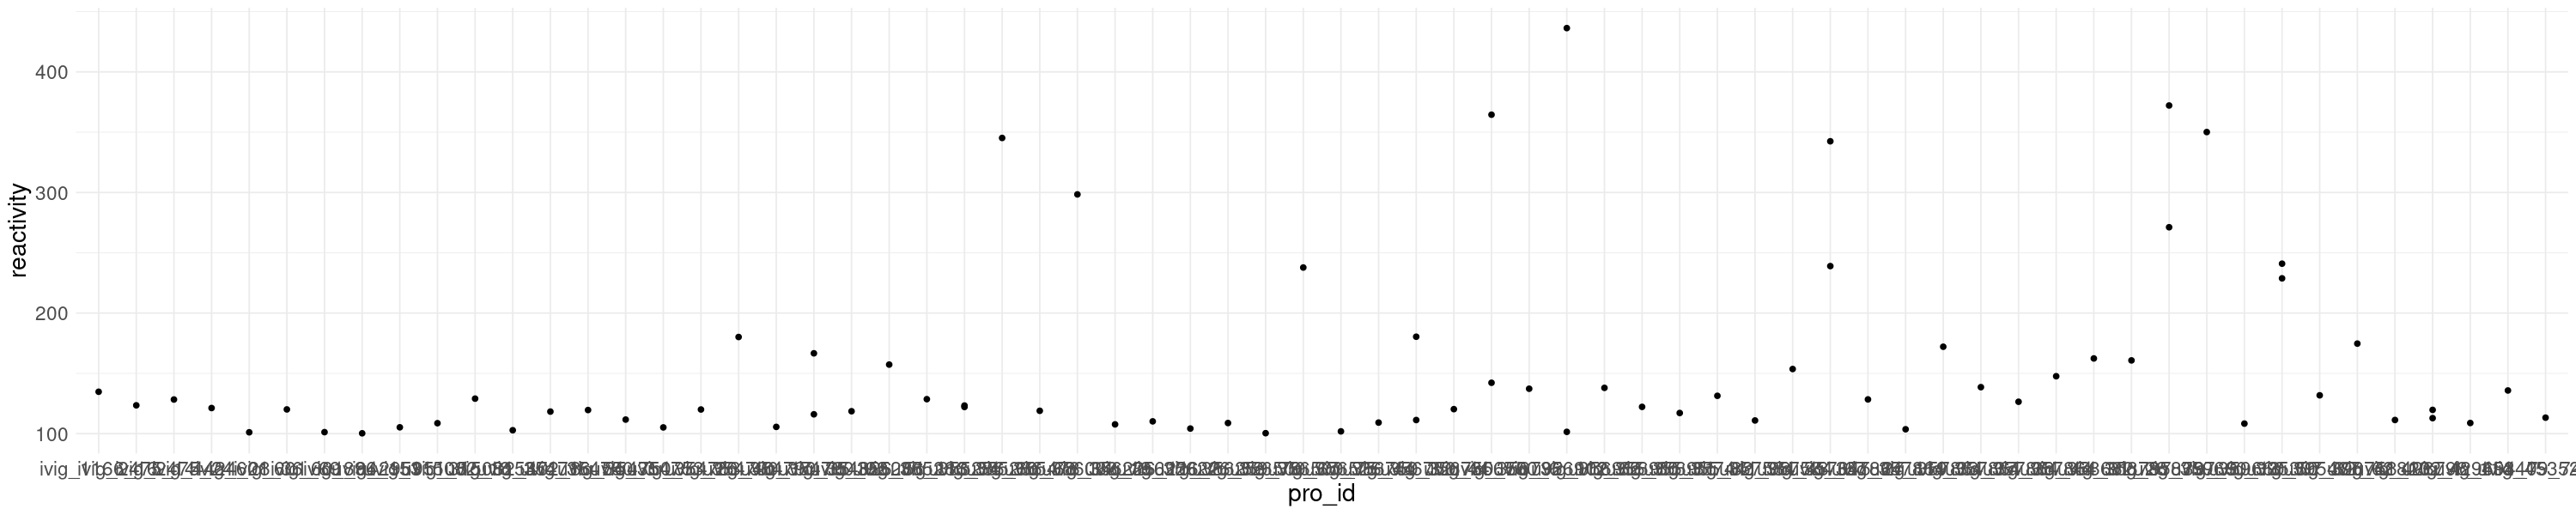

In [169]:
t_anno = t_anno[t_anno$reactivity>100,]
options(repr.plot.width=25, repr.plot.height=5)

ggplot(data=t_anno, aes(x=pro_id, y=reactivity)) +
  geom_point()

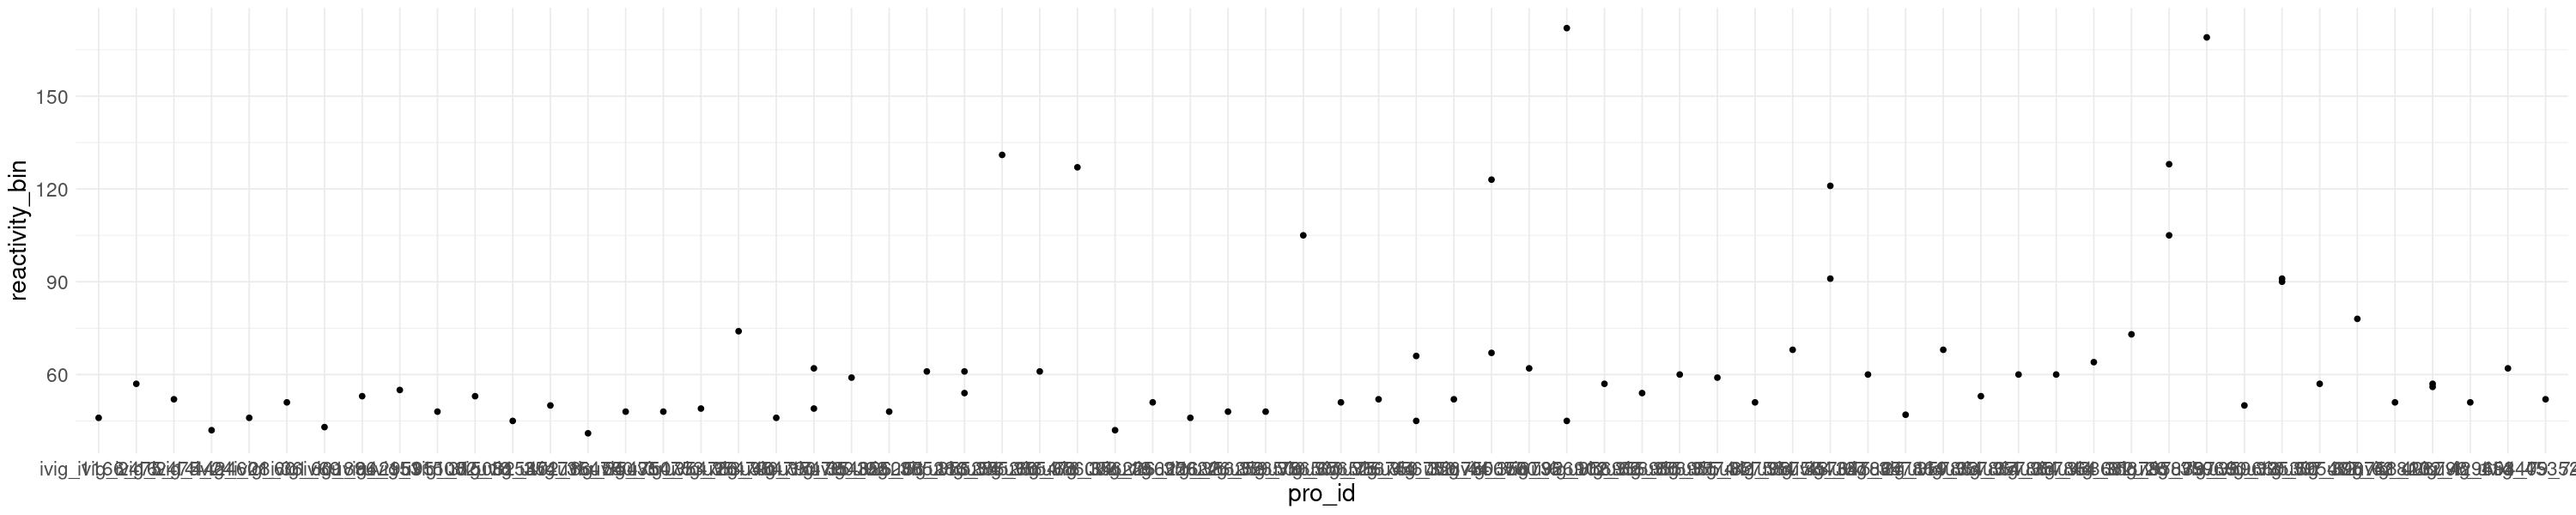

In [170]:
t_anno = t_anno[t_anno$reactivity_bin>2,]
options(repr.plot.width=25, repr.plot.height=5)

ggplot(data=t_anno, aes(x=pro_id, y=reactivity_bin)) +
  geom_point()

In [171]:
# ratios

In [172]:
cutoff = 0

a = dim(anno_pep[grepl("pepsyn", anno_pep$sublibrary),])[1]
print(paste("total pepsyn peptides", a))
b = table(rowSums(lhfc[rownames(anno_pep[grepl("pepsyn", anno_pep$sublibrary),]),])>cutoff)[2]
print(paste("reactive pepsyn peptides", b))
ratio = b/a
print(paste("reactive pepsyn epitopes ratio", ratio))
print("-------------")
a = dim(anno_pep[grepl("dolphinep", anno_pep$sublibrary),])[1]
print(paste("total dolphyn peptides", a))
b = table(rowSums(lhfc[rownames(anno_pep[grepl("dolphinep", anno_pep$sublibrary),]),])>cutoff)[2]
print(paste("reactive dolphyn peptides", b))
ratio = b/a
print(paste("reactive dolphyn epitopes ratio", ratio))
print("-------------")
a = dim(anno_pep["dolphin" == anno_pep$sublibrary,])[1]
print(paste("total dolphyn stitched peptides", a))
b = table(rowSums(lhfc[rownames(anno_pep["dolphin" == anno_pep$sublibrary,]),])>cutoff)[2]
print(paste("reactive dolphyn stitched peptides", b))
ratio = b/a
print(paste("reactive dolphyn stitched ratio", ratio))

[1] "total pepsyn peptides 23745"
[1] "reactive pepsyn peptides 8395"
[1] "reactive pepsyn epitopes ratio 0.353548115392714"
[1] "-------------"
[1] "total dolphyn peptides 19117"
[1] "reactive dolphyn peptides 7523"
[1] "reactive dolphyn epitopes ratio 0.393524088507611"
[1] "-------------"
[1] "total dolphyn stitched peptides 5266"
[1] "reactive dolphyn stitched peptides 3883"
[1] "reactive dolphyn stitched ratio 0.737371819217623"


In [173]:
df = cbind(anno_pep[,c("pro_id","pos_start","pro_len","taxon_id", "sublibrary")],max_IgG = apply(lhfc_igg, 1, max))
df = cbind(df, max_IgA = apply(lhfc_iga, 1, max))

In [174]:
a = dim(df[grepl("pepsyn", df$sublibrary),])[1]
print(paste("total pepsyn peptides", a))

b = dim(df[df$sublibrary == "pepsyn" & df$max_IgG > 0,])[1]
print(paste("reactive pepsyn peptides IgG", b))
ratio_igg = b/a
print(paste("reactive pepsyn epitopes ratio IgG", ratio_igg))

c = dim(df[df$sublibrary == "pepsyn" & df$max_IgA > 0,])[1]
print(paste("reactive pepsyn peptides IgA", c))
ratio_iga = c/a
print(paste("reactive pepsyn epitopes ratio IgA", ratio_iga))
print(paste("normalized by length pepsyn ratio IgA", ratio_iga/56))
print(paste("normalized by length pepsyn ratio IgG", ratio_igg/56))

print("-------------")
a = dim(df[grepl("dolphinepitopes", df$sublibrary),])[1]
print(paste("total dolphinepitopes peptides", a))

b = dim(df[df$sublibrary == "dolphinepitopes" & df$max_IgG > 0,])[1]
print(paste("reactive dolphinepitopes peptides IgG", b))
ratio_igg = b/a
print(paste("reactive dolphinepitopes epitopes ratio IgG", ratio_igg))

c = dim(df[df$sublibrary == "dolphinepitopes" & df$max_IgA > 0,])[1]
print(paste("reactive dolphinepitopes peptides IgA", c))
ratio_iga = c/a
print(paste("reactive dolphinepitopes epitopes ratio IgA", ratio_iga))
print(paste("normalized by length dolphinepitopes ratio IgA", ratio_iga/15))
print(paste("normalized by length dolphinepitopes ratio IgG", ratio_igg/15))
print("-------------")
a = dim(df[grepl("dolphin", df$sublibrary),])[1]
print(paste("total dolphin peptides", a))

b = dim(df[df$sublibrary == "dolphin" & df$max_IgG > 0,])[1]
print(paste("reactive dolphin peptides IgG", b))
ratio_igg = b/a
print(paste("reactive dolphin epitopes ratio IgG", ratio_igg))

c = dim(df[df$sublibrary == "dolphin" & df$max_IgA > 0,])[1]
print(paste("reactive dolphin peptides IgA", c))
ratio_iga = c/a
print(paste("reactive dolphin epitopes ratio IgA", ratio_iga))
print(paste("normalized by length dolphin ratio IgA", ratio_iga/56))
print(paste("normalized by length dolphin ratio IgG", ratio_igg/56))

[1] "total pepsyn peptides 23745"
[1] "reactive pepsyn peptides IgG 7852"
[1] "reactive pepsyn epitopes ratio IgG 0.33068014318804"
[1] "reactive pepsyn peptides IgA 3440"
[1] "reactive pepsyn epitopes ratio IgA 0.144872604758897"
[1] "normalized by length pepsyn ratio IgA 0.00258701079926601"
[1] "normalized by length pepsyn ratio IgG 0.00590500255692928"
[1] "-------------"
[1] "total dolphinepitopes peptides 19117"
[1] "reactive dolphinepitopes peptides IgG 7054"
[1] "reactive dolphinepitopes epitopes ratio IgG 0.368990950462939"
[1] "reactive dolphinepitopes peptides IgA 3362"
[1] "reactive dolphinepitopes epitopes ratio IgA 0.17586441387247"
[1] "normalized by length dolphinepitopes ratio IgA 0.0117242942581646"
[1] "normalized by length dolphinepitopes ratio IgG 0.0245993966975292"
[1] "-------------"
[1] "total dolphin peptides 24383"
[1] "reactive dolphin peptides IgG 3792"
[1] "reactive dolphin epitopes ratio IgG 0.155518188902104"
[1] "reactive dolphin peptides IgA 2001"
[1] 

In [175]:
df

,pro_id,pos_start,pro_len,taxon_id,sublibrary,max_IgG,max_IgA
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
DolphynLa_001_GGTCTGGGCTGGGTACAGCGCGACCGTAGACTGGCAAGTCAGAAAGGTGG,ivig_1427_30,NA,235,ivig_1427,dolphin,3.325396,2.459589
DolphynLa_001_GCTTCATGGCGGGAGAATCGTCATTACCCCCAGCGTATTCTACGCGGGGG,ivig_1427_30,NA,235,ivig_1427,dolphin,2.454447,0.000000
DolphynLa_001_GACGAGATCATCAAGGGCAAATGGGGTAGTAACCCGGAACGCCGTGGAGG,uvig_356033_19,NA,321,uvig_356033,dolphin,3.049273,2.186051
DolphynLa_001_AAAAATTCAGAAAACAAATACTTCCTGAAAGTGTATAAATACATTGGCGG,uvig_355947_23,NA,686,uvig_355947,dolphin,0.000000,0.000000
DolphynLa_001_CGTGAGATTATGGAACGCCGCCACCTGGACATGGAAGATTGGAAGGGTGG,uvig_357441_78,NA,174,uvig_357441,dolphin,3.697839,2.173615
DolphynLa_001_GCTGGAAACTGGATGTATGCATGGTGGAAAAGCGACCGCAAACATGGAGG,ivig_896_163,NA,410,ivig_896,dolphin,1.801710,0.000000
DolphynLa_001_CATTACGTGTGGCAGACGACTAAGAATCGGCGCTGGTTCGGTCCCGGTGG,ivig_896_163,NA,410,ivig_896,dolphin,0.000000,1.704748
DolphynLa_001_GAATTGAGACGTTGGTTTGGAAGAAGAGCCGTTGAGAAACCTTTTGGTGG,ivig_896_163,NA,410,ivig_896,dolphin,0.000000,0.000000
DolphynLa_001_CCGGTATTGGAAAAGGACTTCCATTTTTCAGGATCAGACTGGAATGGTGG,ivig_896_163,NA,410,ivig_896,dolphin,2.298577,1.824549


In [176]:
hfc_cutoff = 0
cutoff = 2

a = dim(anno_pep[grepl("pepsyn", anno_pep$sublibrary),])[1]
print(paste("total pepsyn peptides", a))
b = table(rowSums(lhfc[rownames(anno_pep[grepl("pepsyn", anno_pep$sublibrary),]),]>hfc_cutoff)>cutoff)[2]
print(paste("reactive pepsyn peptides", b))
ratio = b/a
print(paste("reactive pepsyn epitopes ratio", ratio))
print("-------------")
a = dim(anno_pep[grepl("dolphinep", anno_pep$sublibrary),])[1]
print(paste("total dolphyn peptides", a))
b = table(rowSums(lhfc[rownames(anno_pep[grepl("dolphinep", anno_pep$sublibrary),]),]>hfc_cutoff)>cutoff)[2]
print(paste("reactive dolphyn peptides", b))
ratio = b/a
print(paste("reactive dolphyn epitopes ratio", ratio))
print("-------------")
a = dim(anno_pep["dolphin" == anno_pep$sublibrary,])[1]
print(paste("total dolphyn stitched peptides", a))
b = table(rowSums(lhfc[rownames(anno_pep["dolphin" == anno_pep$sublibrary,]),]>hfc_cutoff)>cutoff)[2]
print(paste("reactive dolphyn stitched peptides", b))
ratio = b/a
print(paste("reactive dolphyn stitched ratio", ratio))

[1] "total pepsyn peptides 23745"
[1] "reactive pepsyn peptides 6622"
[1] "reactive pepsyn epitopes ratio 0.278879764160876"
[1] "-------------"
[1] "total dolphyn peptides 19117"
[1] "reactive dolphyn peptides 5978"
[1] "reactive dolphyn epitopes ratio 0.312705968509703"
[1] "-------------"
[1] "total dolphyn stitched peptides 5266"
[1] "reactive dolphyn stitched peptides 3403"
[1] "reactive dolphyn stitched ratio 0.646221040638055"


In [177]:
table(anno_pep$sublibrary)


        dolphin dolphinepitopes          pepsyn    validationDS 
           5266           19117           23745               0 

In [178]:
df = cbind(anno_pep[, c("tile_id","sublibrary")], rowSums(lhfc[rownames(anno_pep),]),rowSums(lhfc[rownames(anno_pep),]>0))
df = df[,2:4]
colnames(df) = c("sublibrary", "reactivity", "reactivity_bin")
df

,sublibrary,reactivity,reactivity_bin
,<fct>,<dbl>,<dbl>
DolphynLa_001_GGTCTGGGCTGGGTACAGCGCGACCGTAGACTGGCAAGTCAGAAAGGTGG,dolphin,81.639484,42
DolphynLa_001_GCTTCATGGCGGGAGAATCGTCATTACCCCCAGCGTATTCTACGCGGGGG,dolphin,14.636143,8
DolphynLa_001_GACGAGATCATCAAGGGCAAATGGGGTAGTAACCCGGAACGCCGTGGAGG,dolphin,15.364996,8
DolphynLa_001_AAAAATTCAGAAAACAAATACTTCCTGAAAGTGTATAAATACATTGGCGG,dolphin,0.000000,0
DolphynLa_001_CGTGAGATTATGGAACGCCGCCACCTGGACATGGAAGATTGGAAGGGTGG,dolphin,10.323619,4
DolphynLa_001_GCTGGAAACTGGATGTATGCATGGTGGAAAAGCGACCGCAAACATGGAGG,dolphin,8.578638,5
DolphynLa_001_CATTACGTGTGGCAGACGACTAAGAATCGGCGCTGGTTCGGTCCCGGTGG,dolphin,1.704748,1
DolphynLa_001_GAATTGAGACGTTGGTTTGGAAGAAGAGCCGTTGAGAAACCTTTTGGTGG,dolphin,0.000000,0
DolphynLa_001_CCGGTATTGGAAAAGGACTTCCATTTTTCAGGATCAGACTGGAATGGTGG,dolphin,5.765999,3


In [179]:
table(df$reactivity_bin)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
28327  2429  1369  1073   998   950   885   836   809   732   757   753   680 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
  661   625   599   538   506   468   390   398   351   323   285   256   222 
   26    27    28    29    30    31    32    33    34    35    36    37    38 
  204   191   169   134   151   138   102    82    82    68    56    59    47 
   39    40    41    42    43    44    45    46    47    48    49    50    51 
   48    40    29    29    24    22    18    22    10    13    11     7    16 
   52    53    54    55    56    57    58    59    60    61    62    63    64 
   12     7     7    10     5     9     6     8     7     6     3     4     4 
   66    67    68    69    70    71    72    73    74    77    78    81    82 
    4     1     5     1     2     2     2     1     2     2     1     1     1 
   83    86    90    91    93    94    97   103   1

Warning message:
“Removed 1845 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


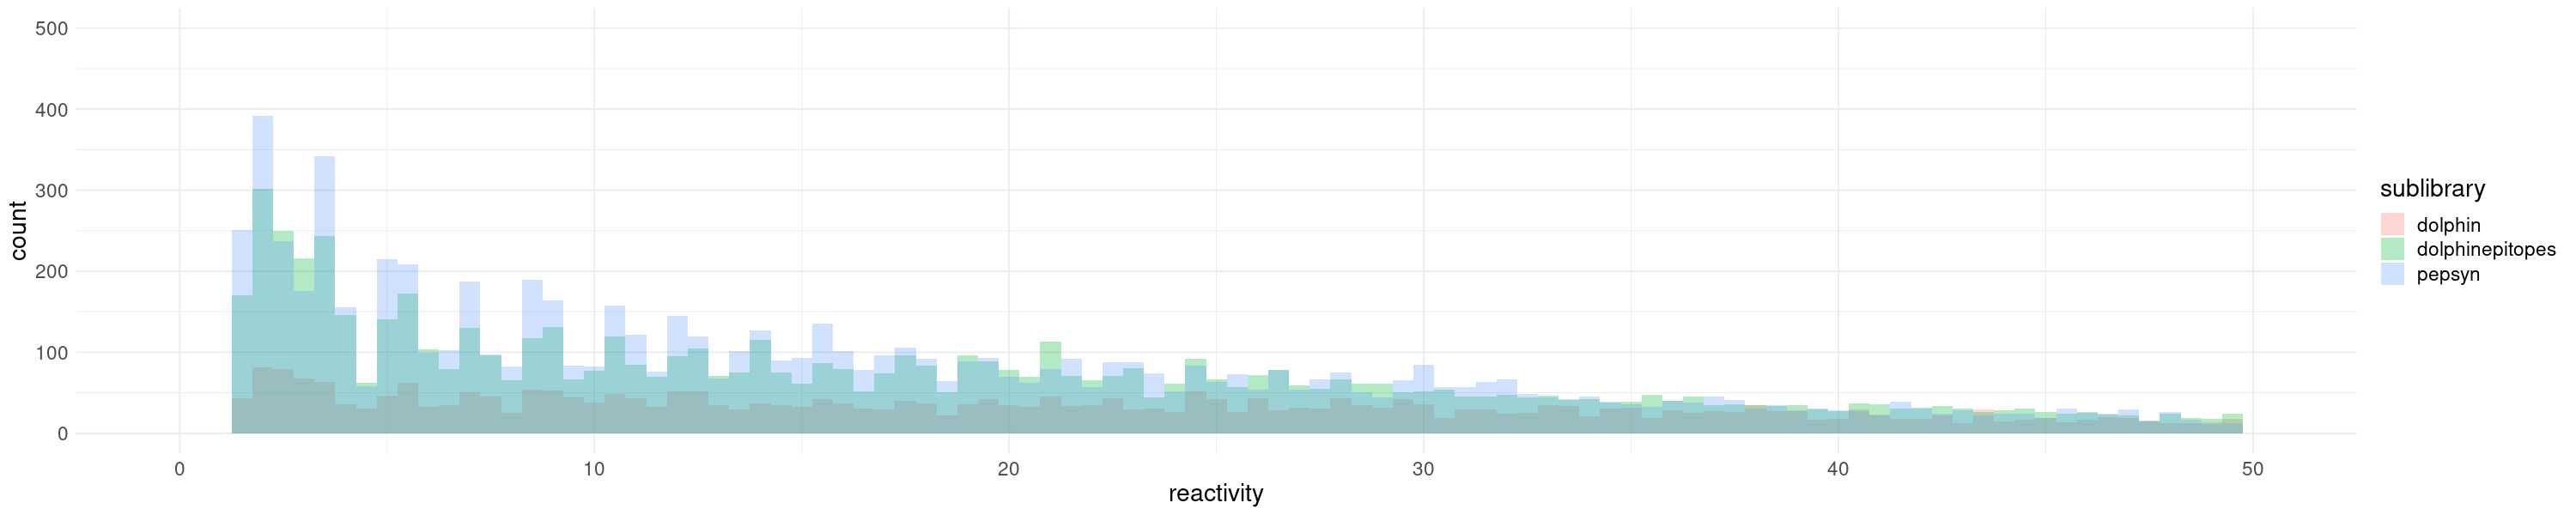

In [180]:
ggplot(df, aes(x=reactivity, fill=sublibrary)) +
    geom_histogram(position = 'identity', binwidth=0.5, alpha=0.3) + 
    xlim(c(0,50)) + ylim(c(0,500))

Warning message:
“Removed 1845 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


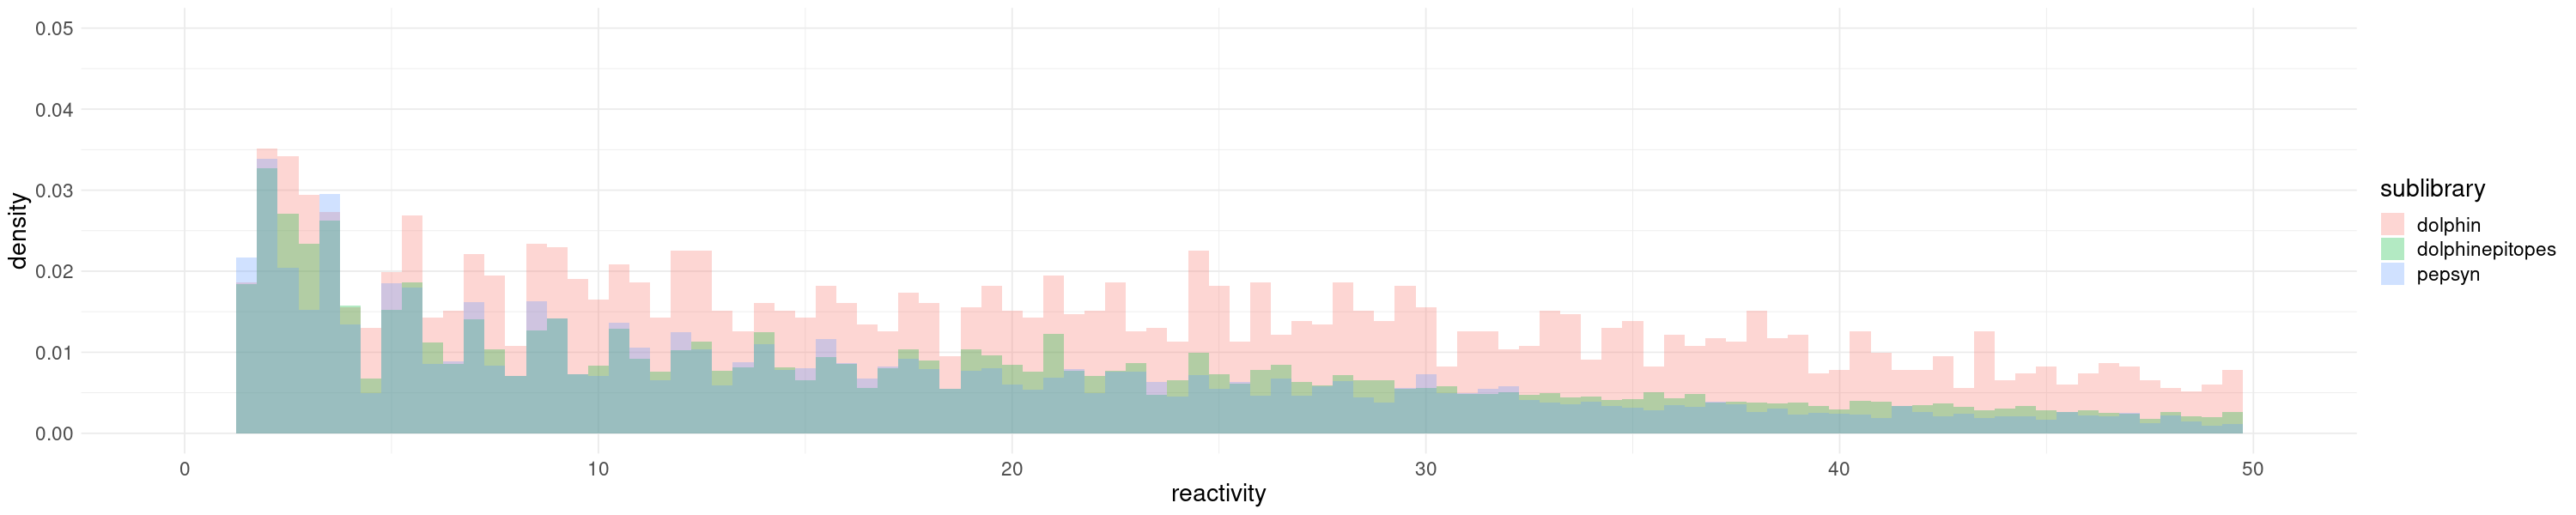

In [181]:
ggplot(df, aes(x=reactivity, fill=sublibrary)) +
    geom_histogram(aes(y=..density..),position = 'identity', binwidth=0.5, alpha=0.3) + 
    xlim(c(0,50)) + ylim(c(0,0.05))

In [182]:
# still not what i want as is should be a cutoff

In [183]:
df[df$sublibrary=="dolphin","ratio"] = df[df$sublibrary=="dolphin","reactivity"] / 5266
df[df$sublibrary=="dolphinepitopes","ratio"] = df[df$sublibrary=="dolphinepitopes","reactivity"] / 19117
df[df$sublibrary=="pepsyn","ratio"] = df[df$sublibrary=="pepsyn","reactivity"] / 23745
df

,sublibrary,reactivity,reactivity_bin,ratio
,<fct>,<dbl>,<dbl>,<dbl>
DolphynLa_001_GGTCTGGGCTGGGTACAGCGCGACCGTAGACTGGCAAGTCAGAAAGGTGG,dolphin,81.639484,42,0.0155031303
DolphynLa_001_GCTTCATGGCGGGAGAATCGTCATTACCCCCAGCGTATTCTACGCGGGGG,dolphin,14.636143,8,0.0027793664
DolphynLa_001_GACGAGATCATCAAGGGCAAATGGGGTAGTAACCCGGAACGCCGTGGAGG,dolphin,15.364996,8,0.0029177737
DolphynLa_001_AAAAATTCAGAAAACAAATACTTCCTGAAAGTGTATAAATACATTGGCGG,dolphin,0.000000,0,0.0000000000
DolphynLa_001_CGTGAGATTATGGAACGCCGCCACCTGGACATGGAAGATTGGAAGGGTGG,dolphin,10.323619,4,0.0019604289
DolphynLa_001_GCTGGAAACTGGATGTATGCATGGTGGAAAAGCGACCGCAAACATGGAGG,dolphin,8.578638,5,0.0016290615
DolphynLa_001_CATTACGTGTGGCAGACGACTAAGAATCGGCGCTGGTTCGGTCCCGGTGG,dolphin,1.704748,1,0.0003237273
DolphynLa_001_GAATTGAGACGTTGGTTTGGAAGAAGAGCCGTTGAGAAACCTTTTGGTGG,dolphin,0.000000,0,0.0000000000
DolphynLa_001_CCGGTATTGGAAAAGGACTTCCATTTTTCAGGATCAGACTGGAATGGTGG,dolphin,5.765999,3,0.0010949485


In [184]:
max(df$reactivity)

[1] 436.3158

In [185]:
table(anno_pep$sublibrary)["dolphin"]

dolphin 
   5266

In [186]:
tab_fullnumbers = table(anno_pep$sublibrary)
react_ratio <- function(cutoff, lib){
    a = tab_fullnumbers[lib]
    b = table(rowSums(lhfc[rownames(anno_pep[lib == anno_pep$sublibrary,]),])>cutoff)[2]
    ratio = b/a
    return(ratio)
}

react_ratio_bin <- function(cutoff, lib, bin_cutoff=1){
    a = tab_fullnumbers[lib]
    b = table(rowSums(lhfc[rownames(anno_pep[lib == anno_pep$sublibrary,]),]>bin_cutoff)>cutoff)[2]
    ratio = b/a
    return(ratio)
}

df2 = data.frame(r_cutoff=rep(seq(0,100,10),3), library = c(rep("dolphin",11),rep("dolphinepitopes",11),rep("pepsyn",11)))
df2$ratio = mapply(react_ratio, df2$r_cutoff, df2$library)
#df2

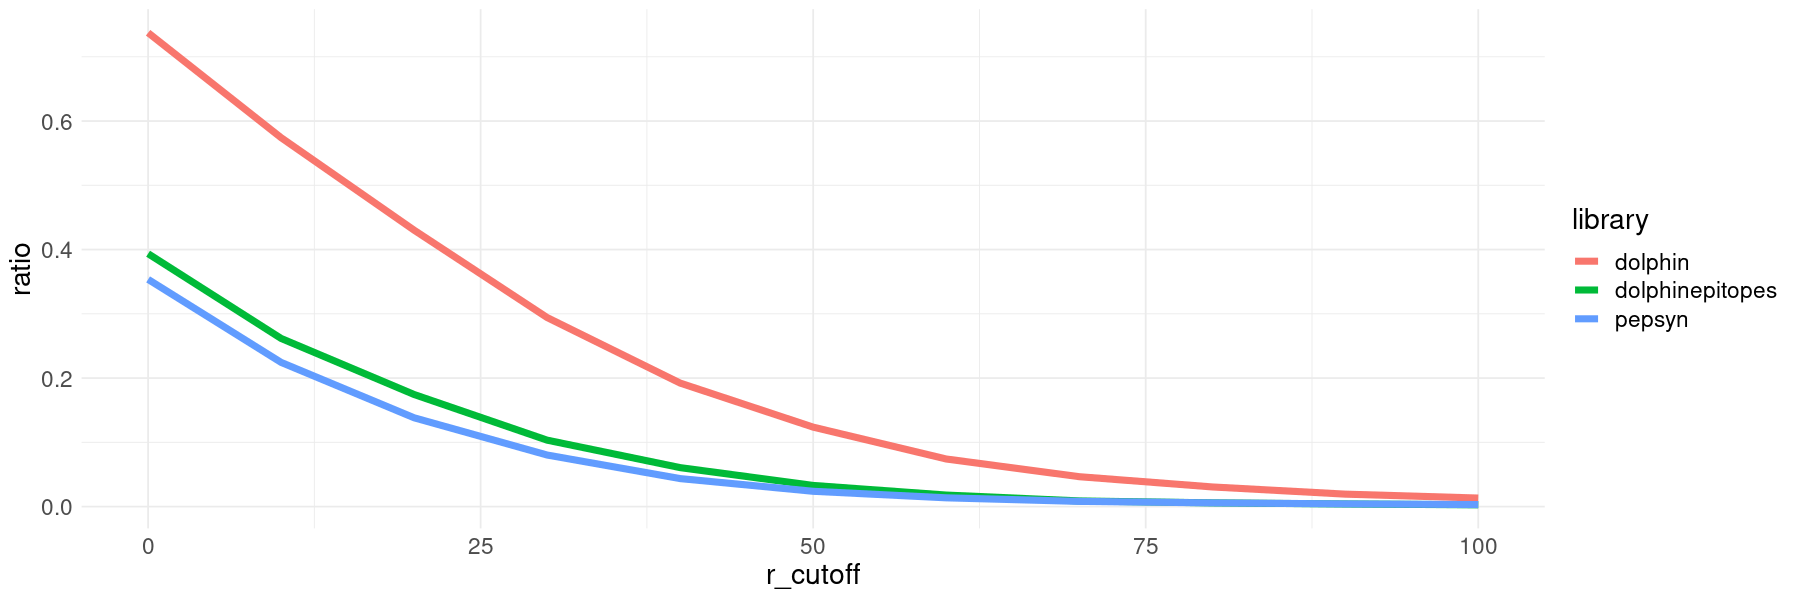

In [187]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot(df2, aes(x=r_cutoff, y=ratio, color=library)) + geom_line(size=2) 

In [188]:
df2 = data.frame(r_cutoff=rep(seq(0,100,10),3), library = c(rep("dolphin",11),rep("dolphinepitopes",11),rep("pepsyn",11)))
df2$ratio_bin = mapply(react_ratio_bin, df2$r_cutoff, df2$library)

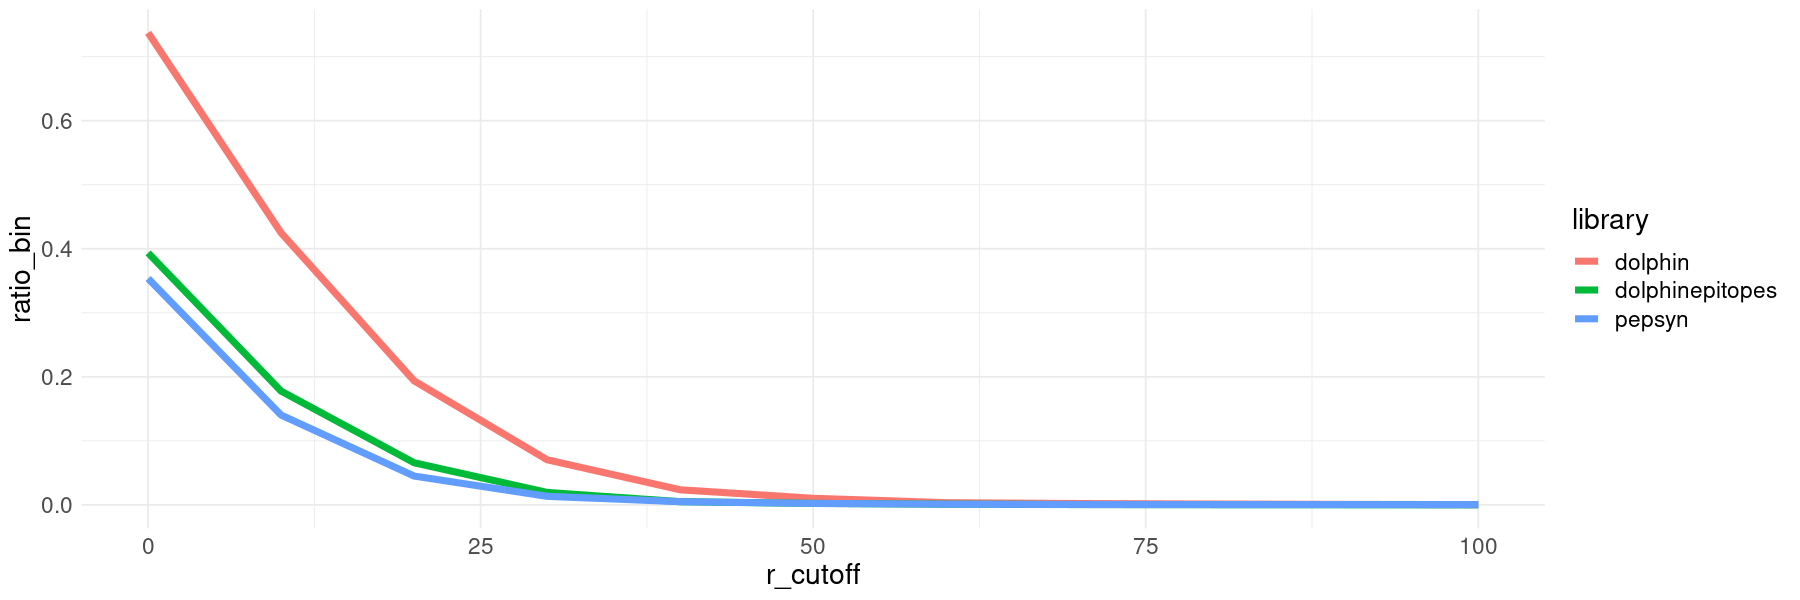

In [189]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot(df2, aes(x=r_cutoff, y=ratio_bin, color=library)) + geom_line(size=2) 

In [190]:
# are the same epitopes detected?

In [191]:
# go on individual sample base

In [192]:
proteinID = "ivig_2475_41"

t_anno = anno_pep[anno_pep$pro_id== proteinID,]
t_hfc = hfc[rownames(t_anno),colSums(lhfc[rownames(t_anno),])>60]

In [193]:
df = cbind(t_hfc,t_anno[,c("pos_start", "pro_len", "sublibrary")])
df = cbind(rowSums(t_hfc), df)

In [194]:
#additionalrows = df[df$sublibrary == "pepsyn",]
#additionalrows$pos_start = additionalrows$pos_start + 56
#df = rbind(df, additionalrows)
#additionalrows = df[df$sublibrary == "dolphinepitopes",]
#additionalrows$pos_start = additionalrows$pos_start + 15
#df = rbind(df, additionalrows)
df[df$sublibrary=="dolphin","pos_start"] = 0
#additionalrows = df[df$sublibrary == "dolphin",]
#additionalrows$pos_start = additionalrows$pos_start + df[1,"pro_len"]
#df = rbind(df, additionalrows)
#df = df[order(df$sublibrary),]
#df = df[order(df$pos_start),]
#df[df$sublibrary == "dolphin","sublibrary"][1] = "dolphin1"
#df[df$sublibrary == "dolphin","sublibrary"][2] = "dolphin2"
#df[df$sublibrary == "dolphin","sublibrary"][3] = "dolphin1"
#df[df$sublibrary == "dolphin","sublibrary"][4] = "dolphin2"

In [195]:
# ivig_2475_41
# predicted species : Podoviridae
# predicted host : Proteobacteria/Gammaproteobacteria/Enterobacterales/Enterobacteriaceae/Escherichia/Escherichia coli
# also clustered with ivig_2643_20

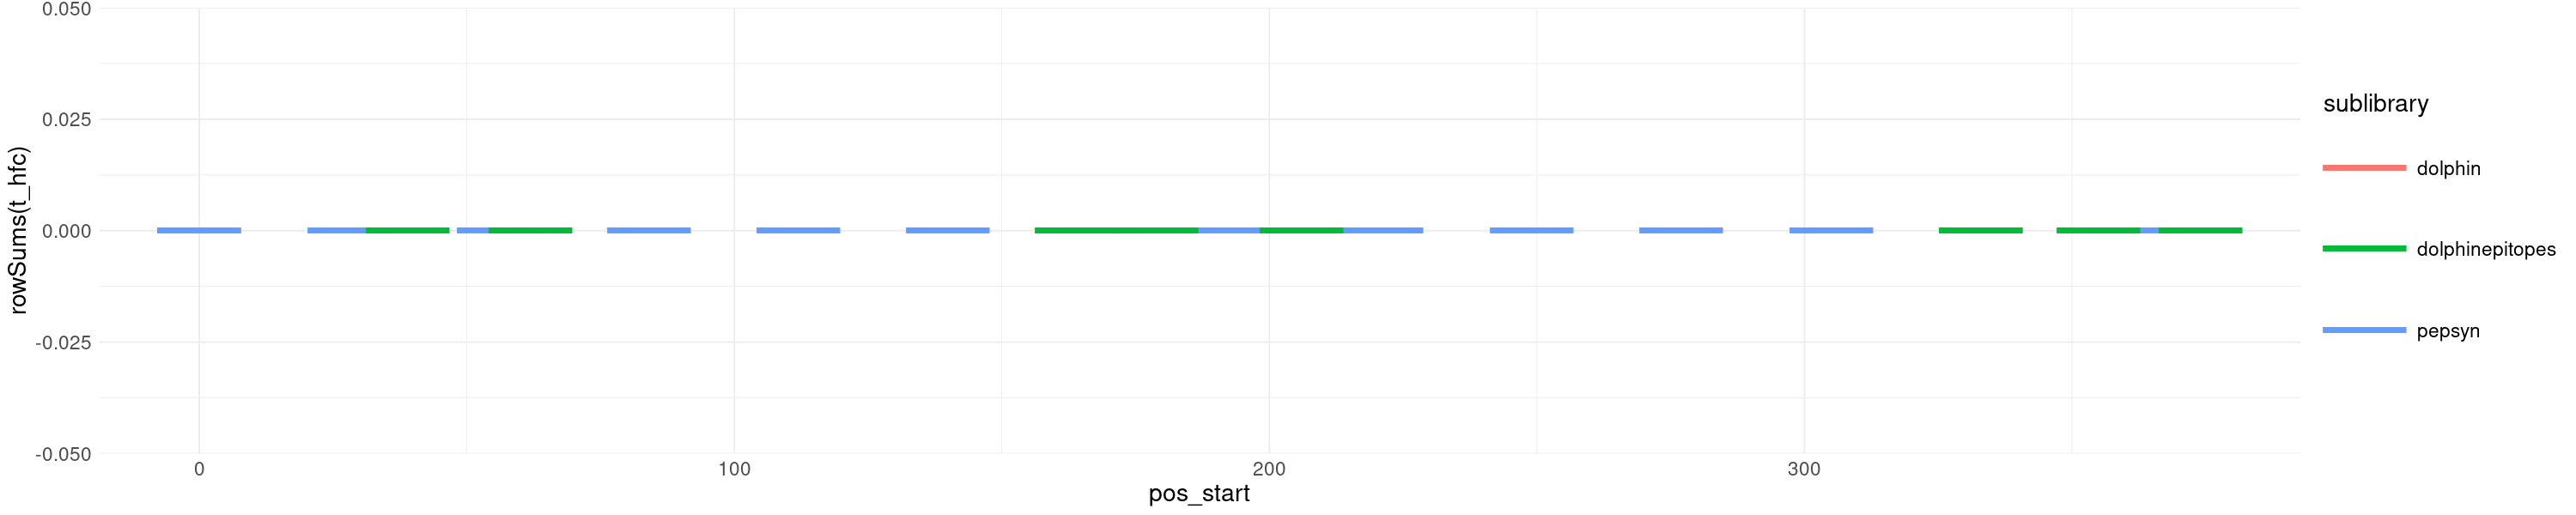

In [196]:
options(repr.plot.width=25, repr.plot.height=5)
ggplot(data=df, aes(x=pos_start, y=rowSums(t_hfc), group=sublibrary)) +
  geom_point(aes(color=sublibrary), shape = "\U2014", size = 20) 


In [197]:
df = melt(df,id.vars=c("pos_start","pro_len","sublibrary","rowSums(t_hfc)"), variable.name="sample", value.name="hfc")

Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.

ERROR while rich displaying an object: Error in `check_aesthetics()`:
! Aesthetics must be either length 1 or the same as the data (24): y

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     pre

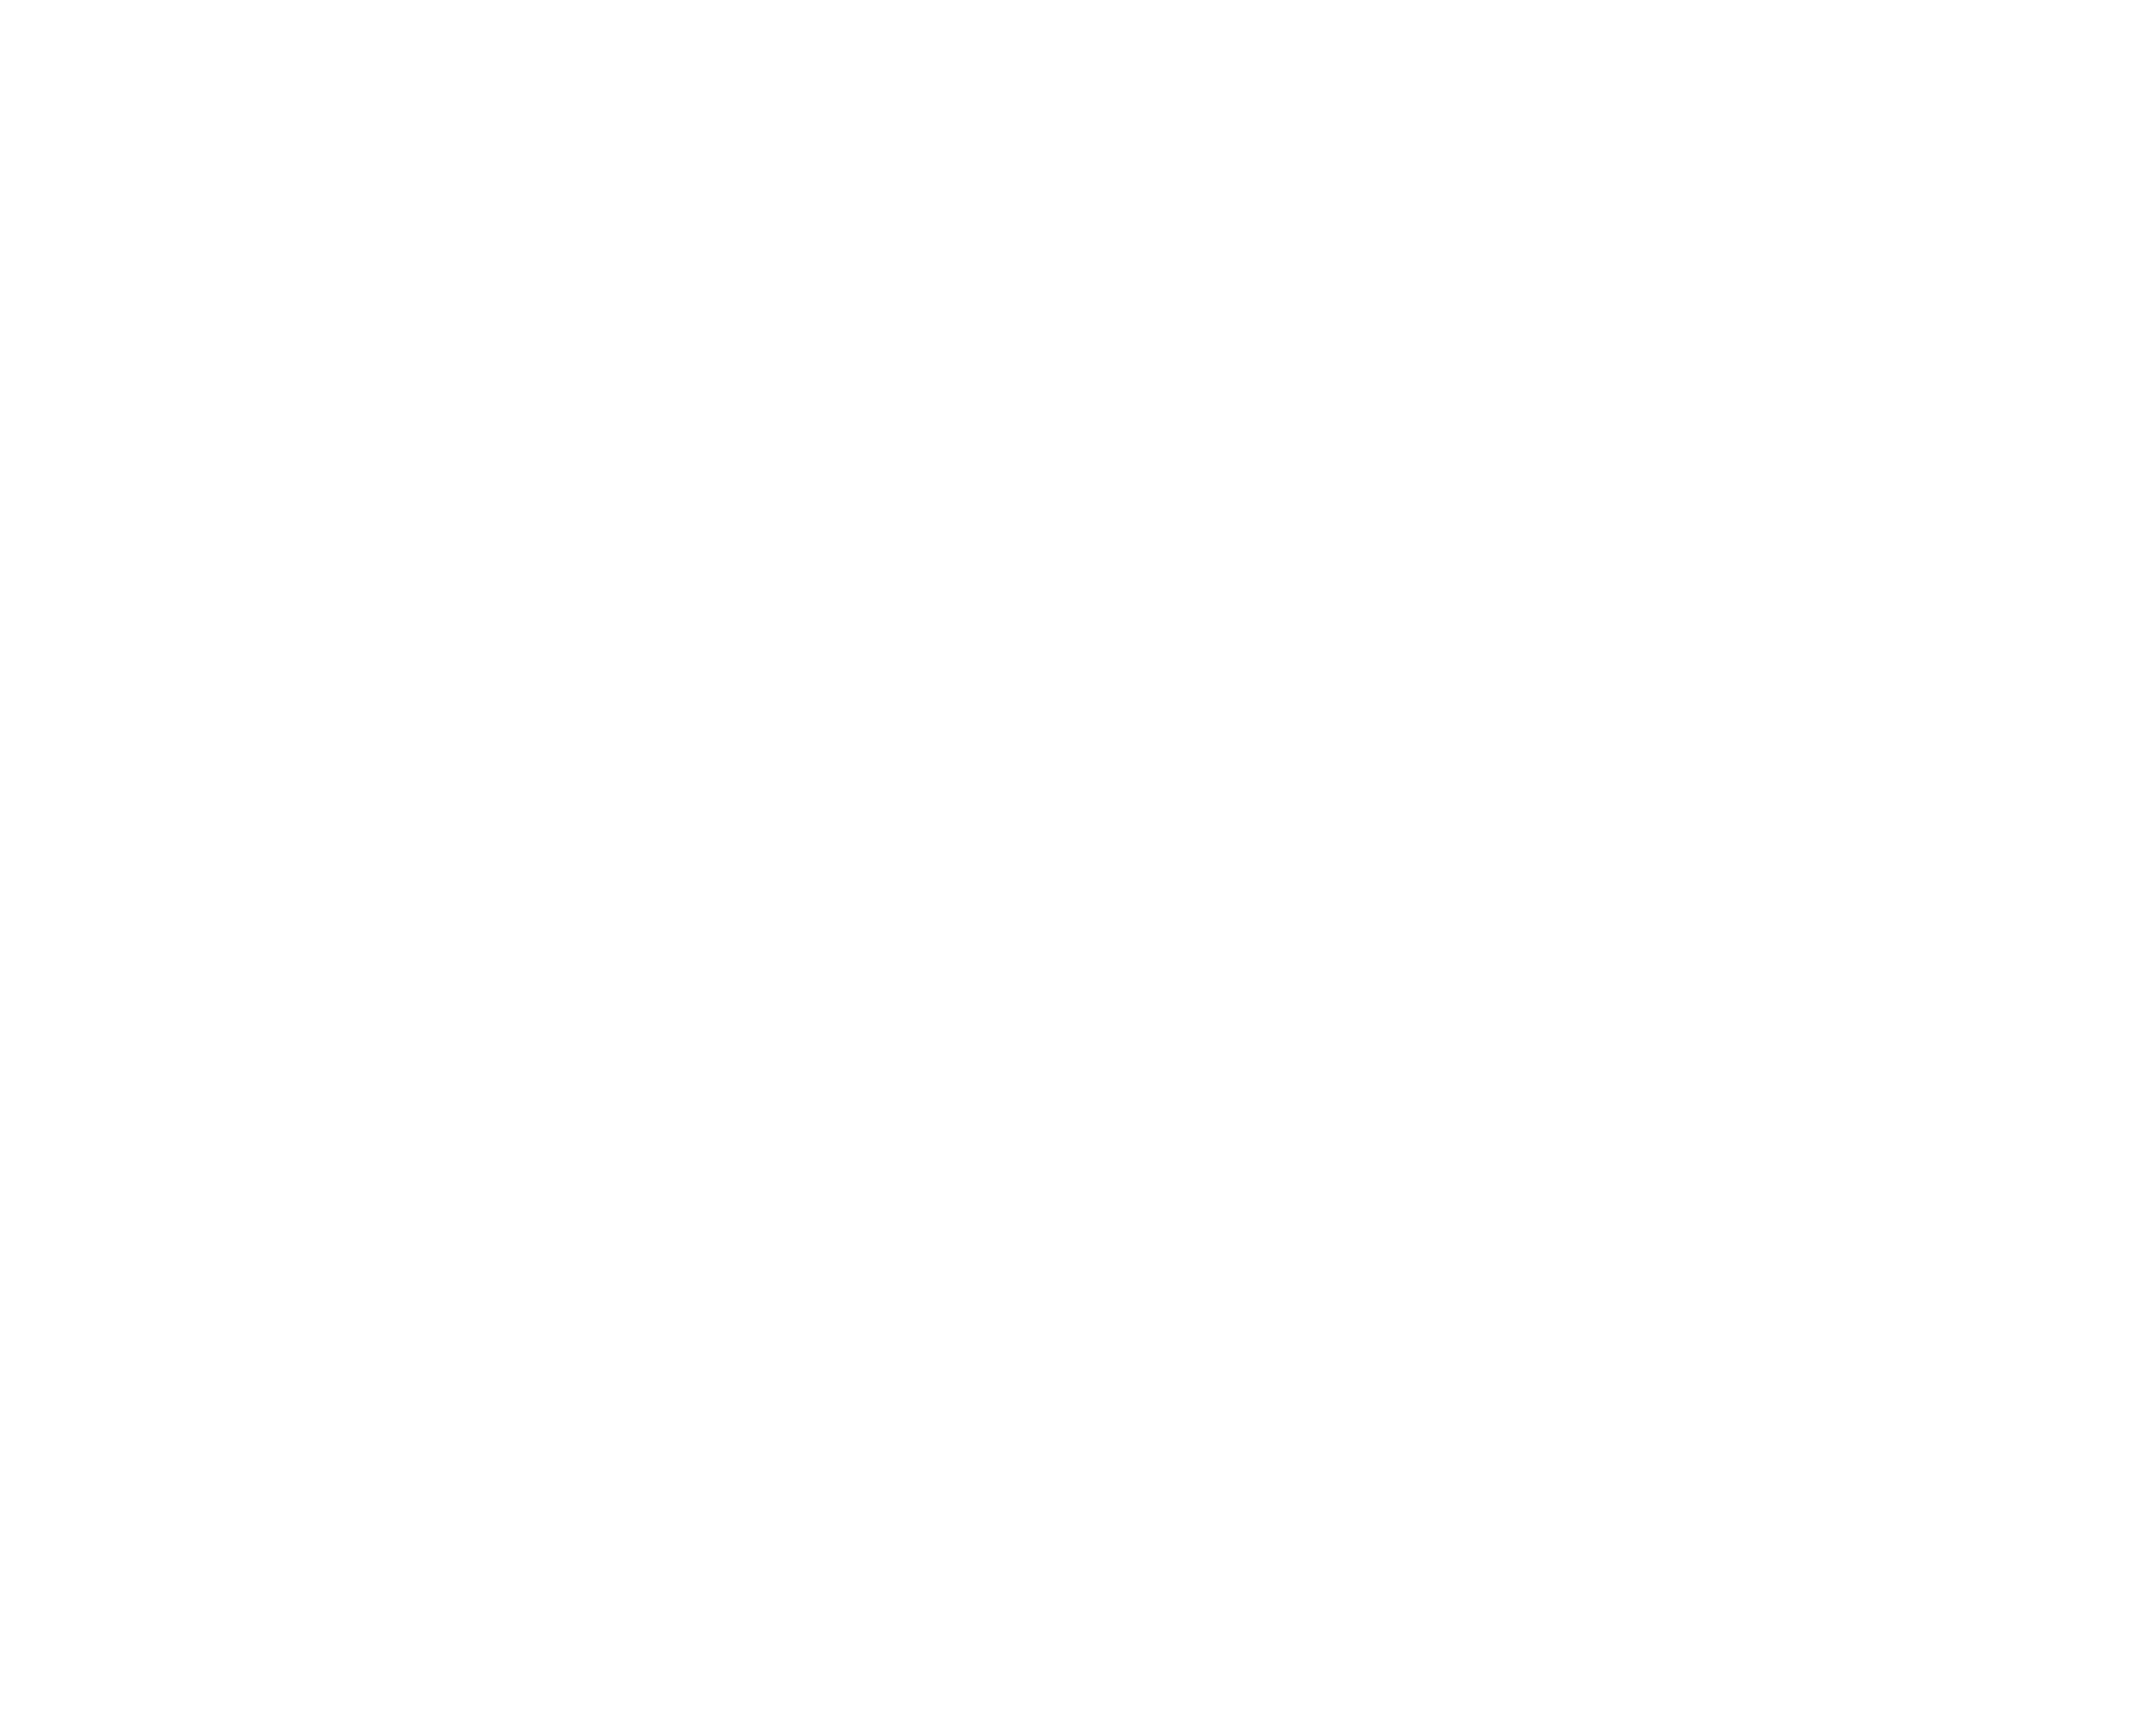

In [198]:
options(repr.plot.width=25, repr.plot.height=20)
ggplot(data=df, aes(x=pos_start, y=hfc, group=sublibrary)) +
  geom_point(aes(color=sublibrary), shape = "\U2014", size = 20) +
  facet_grid(rows = df$sample)
